# <a id=top><center><font size=6.7>🗓 M5 Forecasting - Accuracy 📆</font></center></a>

## <div class="pull-right">2017025769 신선웅 🙋🏻‍♂️<br>2018005478 신민경 🙋</div><br>
## <div class="pull-right">🙋🏻‍♂️🙋I swear this notebook didn't fork others</div>

# <font size=7>Content</font><br>
<font size=3>
    
**[1. Introduction](#1)**

  * [1.1. Overview](#1-1)
  * [1.2. Initial Setting](#1-2)
  * [1.3. Evaluation](#1-3)
  * [1.4. Leaderboard](#1-4)
    
**[2. The Datasets](#2)**

  * [2.1. Calendar.csv](#2-1)
  * [2.2. Sell_prics.csv](#2-2)
  * [2.3. Sales_train_validaiton.csv](#2-3)
  * [2.4. Sales_train_evaluaton.csv](#2-4)
  * [2.5. Submission.csv](#2-5)

**[3. Exploratory Data Analysis](#3)**

  * [3.1 NaN Check](#3-1)
  * [3.2 Special Days](#3-2)
      * [3.2.1 Event Days](#3-2-1)
      * [3.2.2 Snap Days](#3-2-2)
  * [3.3. Sales Analysis](#3-3)
      * [3.3.1 Calendar Plot](#3-3-1)
      * [3.3.2 Category Plot](#3-3-2)
      * [3.3.3 Sales Plot](#3-3-3)
  * [3.4. Sample Data](#3-4)    
    
**[4. Feature Engineering](#4)**

  * [4.1 Data Memory Reducing](#4-1)
  * [4.2 Features Generation](#4-2)
      * [4.2.1 Calendar](#4-2-1)
      * [4.2.2 Sell Prices](4-2-2)
      * [4.2.3 Sales](4-2-3)
  * [4.3 Test Set Generation](#4-3)
    
**[5. Modeling](#5)**

  * [5.1 Time Series Modeling](#5-1)
      * [5.1.1 Simple Moving Average](#5-1-1)
      * [5.1.2 Simple Exponential Smoothing](#5-1-2)
      * [5.1.3 Double Exponential Smoothing](#5-1-3)
      * [5.1.4 Prophet](#5-1-4)
      * [5.1.5 ARIMA](#5-1-5)
    
  * [5.2 Tree Modeling](#5-2)
      * [5.2.1 Setting](#5-2-1)
      * [5.2.2 LightGBM](#5-2-2)
      * [5.2.3 XGBoost](#5-2-3)
    
**[6. Ensemble](#6)**

  * [6.1 Blending](#6-1)
    
**[7. Other Trials](#7)**
  * [7.1 Calendar Features](#7-1)
  * [7.2 Lag, Window Features](#7-2)
  * [7.3 Tree Modeling](#7-3)
  * [7.4 Neural Network Modeling](#7-4)
    
</font>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100, 'display.max_columns', 30)
from  datetime import datetime, timedelta
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')
import random
import pickle
from typing import Union

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode()

import missingno

import pyecharts
pyecharts.online()
from pyecharts import Line, Bar, Pie, Overlap, Gauge
from IPython.display import display, Image

import bokeh
from bokeh.io import show
from bokeh.palettes import Spectral9
from bokeh.plotting import figure, show, output_notebook, reset_output
output_notebook()

import altair as alt

import calplot

import colorcet as cc
rgb_light_palette = [(0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]
light_palette = np.array(rgb_light_palette)/255

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet import Prophet
import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance, plot_metric, plot_tree
import xgboost as xgb
from xgboost import XGBRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

Loading BokehJS ...

In [2]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)
    
wrmsse_calendar = pd.read_csv('../../m5-data/calendar.csv')
wrmsse_prices = pd.read_csv('../../m5-data/sell_prices.csv')
wrmsse_sales = pd.read_csv('../../m5-data/sales_train_evaluation.csv')
wrmsse_train_df = wrmsse_sales.iloc[:, :-28]
wrmsse_valid_df = wrmsse_sales.iloc[:, -28:]

evaluator = WRMSSEEvaluator(wrmsse_train_df, wrmsse_valid_df, wrmsse_calendar, wrmsse_prices)

In [3]:
def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in range(1,13):
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

        trn = create_viz_df(getattr(evaluator, f'lv{i}_train_df')\
                            .iloc[:, -28*3:], i)
        val = create_viz_df(getattr(evaluator, f'lv{i}_valid_df'), i)
        pred = create_viz_df(getattr(evaluator, f'lv{i}_valid_preds'), i)

        n_cate = trn.shape[1] if i < 7 else 9

        fig, axs = plt.subplots(n_rows[i-1], n_cols[i-1], 
                                figsize=(width[i-1],height[i-1]))
        if i > 1:
            axs = axs.flatten()

        ## Time series plot
        for k in range(0, n_cate):

            ax = axs[k] if i > 1 else axs

            trn.iloc[:, k].plot(ax=ax, label='train')
            val.iloc[:, k].plot(ax=ax, label='valid')
            pred.iloc[:, k].plot(ax=ax, label='pred')
            ax.set_title(f"{trn.columns[k]}  RMSSE:{scores[k]:.4f}", size=14)
            ax.set(xlabel='', ylabel='sales')
            ax.tick_params(labelsize=8)
            ax.legend(loc='upper left', prop={'size': 10})

        if i == 1 or i >= 9:
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 , 
                         y=1.1, fontweight='bold')
        plt.tight_layout()
        plt.show()

In [4]:
def wrmsse_lgb(y_pred, dataset):
    
    wrmsse = evaluator.score(y_pred.reshape(28, -1).T)
    
    return 'wrmsse', wrmsse, False

In [5]:
def wrmsse_xgb(y_pred, dataset):
    
    wrmsse = evaluator.score(y_pred.reshape(28, -1).T)
    
    return 'wrmsse', wrmsse

# <a id='4'><font size=6>4. Feature Engineering</font></a>

Load csv files for Feature Engineering. This time, to save memory, I have loaded it according to the certain type.<br>
Feature Engineering을 위하여 데이터들을 불러왔습니다. 이번에는 메모리를 절약하기 위해 정해진 타입에 맞게 불러왔습니다.

In [6]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32'}
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32"}
SALES_DTYPES = {"id": "category", 'item_id': "category", 'dept_id': "category", 'store_id': "category", 
                "cat_id": "category", 'state_id': "category"}
for i in range(1942):
    SALES_DTYPES[f'd_{i}'] = np.int16

In [7]:
calendar = pd.read_csv('../../m5-data/calendar.csv', dtype=CAL_DTYPES)
sell_prices = pd.read_csv('../../m5-data/sell_prices.csv', dtype=PRICE_DTYPES)
sales_train_validation = pd.read_csv('../../m5-data/sales_train_validation.csv', dtype=SALES_DTYPES)
sales_train_evaluation = pd.read_csv('../../m5-data/sales_train_evaluation.csv', dtype=SALES_DTYPES)

In [8]:
sales_train_evaluation

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  ...  \
0         CA_1       CA    0    0    0    0    0    0    0    0    0  ...   
1         CA_1       CA    0    0    0    0    0    0    0    0    0  ...   
2         CA_1       CA    0    0    0    0    0    0    0    0    0  ...   
3         CA_1       CA    0    0    0    0    0    0    0    0    0  ...   
4         CA_1       CA    0    0    0    0    0    0    0    0    0  ...   
...        ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
30485     WI_3       WI    0    0    2    2    0    3    1    4    1  ...   
30486     WI_3       WI    0    0    0    0    0    5    0    1    1  ...   
30487     WI_3       WI    0    6    0    2    2    4    1    8    5  ...   
30488     WI_3       WI    0    0    0    0    0    0    0    0    0  ...   
30489     WI_3       WI    0    0    0    0    0    0    0    0    0  ...   

       d_1927  d_1928  d_1929  d_1930  d_1931  d_1932  d_1933  d_1934  d_1935  \
0           1       2       2       1       0       2       4       0       0   
1           0       0       0       0       0       0       1       2       1   
2           3       0       0       1       0       1       0       2       0   
3           4       2       1       1       1       1       1       0       4   
4           3       2       2       2       2       0       0       0       2   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
30485       1       0       0       1       0       1       0       3       0   
30486       0       0       0       0       0       0       0       0       0   
30487       1       0       3       3       1       0       0       1       2   
30488       1       1       0       2       1       1       1       1       4   
30489       1       1       0       0       0       1       2       0       5   

       d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
0           0       0       3       3       0       1  
1           1       0       0       0       0       0  
2           0       0       2       3       0       1  
3           0       1       3       0       2       6  
4           1       0       0       2       1       0  
...       ...     ...     ...     ...     ...     ...  
30485       1       1       0       0       1       1  
30486       0       0       1       0       1       0  
30487       0       1       0       1       0       2  
30488       6       0       1       1       1       0  
30489       4       0       2       2       5       1  

[30490 rows x 1947 columns]

# <a id=4-1></a>4.1 Features Generation

I melted the date column into one column and added other features.<br>
날짜 컬럼을 하나의 컬럼으로 녹인 후 다른 feature들을 추가해주었습니다.

<img src='https://raw.githubusercontent.com/AIdward/m5-forecasting/master/src/melt.PNG' style='float:left; width:900px;'>

In [9]:
train = pd.melt(sales_train_evaluation, id_vars=['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'],
                                 value_vars = [col for col in sales_train_evaluation.columns if col.startswith("d_")],
                                 var_name = "d", value_name = "sales")
train

id        item_id    dept_id store_id  \
0         HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1     CA_1   
1         HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1     CA_1   
2         HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1     CA_1   
3         HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1     CA_1   
4         HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1     CA_1   
...                                 ...            ...        ...      ...   
59181085    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3     WI_3   
59181086    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3     WI_3   
59181087    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3     WI_3   
59181088    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3     WI_3   
59181089    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3     WI_3   

           cat_id state_id       d  sales  
0         HOBBIES       CA     d_1      0  
1         HOBBIES       CA     d_1      0  
2         HOBBIES       CA     d_1      0  
3         HOBBIES       CA     d_1      0  
4         HOBBIES       CA     d_1      0  
...           ...      ...     ...    ...  
59181085    FOODS       WI  d_1941      1  
59181086    FOODS       WI  d_1941      0  
59181087    FOODS       WI  d_1941      2  
59181088    FOODS       WI  d_1941      0  
59181089    FOODS       WI  d_1941      1  

[59181090 rows x 8 columns]

## <a id=4-1-1></a>(1) Calendar

Created one feature by averaging the sales of each event day. It's because the **curse of dimentionality** when you do one hot encoding.<br>
각 이벤트날의 판매를 평균내어 하나의 컬럼을 만들었습니다. 원 핫 인코딩을 할 시 차원에 저주에 걸릴 수 있기 때문입니다.

In [10]:
calendar2 = pd.read_csv('../../m5-data/calendar.csv')
sales_train_evaluation2 = pd.read_csv('../../m5-data/sales_train_evaluation.csv')
d_cols = [c for c in sales_train_evaluation2.columns if 'd_' in c]
past_sales = sales_train_evaluation2.set_index('id')[d_cols].T.merge(calendar2.set_index('d')['date'],
                                                                    left_index=True, right_index=True, 
                                                                    validate='1:1').set_index('date')
past_sales_sum = pd.DataFrame(past_sales.sum(axis=1))
event_df = calendar2[calendar2['event_name_1'].notna()][['date', 'event_name_1']].set_index('date')
event_sales = pd.concat([past_sales_sum, event_df],axis=1)
event_sales = event_sales.fillna({'event_name_1':'NormalDay'})
event_sales = event_sales.dropna()
event_sales = event_sales.groupby(event_sales['event_name_1']).mean().sort_values(by=0, ascending=True)
event_dict = {np.nan: event_sales[0]['NormalDay']}
for i in range(len(event_sales)):
    event_dict[event_sales.index[i]] = event_sales[0][i]
event_dict

{nan: 34609.33651149747,
 'Christmas': 15.6,
 'Thanksgiving': 21130.0,
 'NewYear': 25768.4,
 'LentWeek2': 29747.0,
 'Halloween': 30059.4,
 'LentStart': 30727.0,
 'NBAFinalsStart': 31874.4,
 'MemorialDay': 32699.6,
 'OrthodoxChristmas': 33344.2,
 'MartinLutherKingDay': 33378.6,
 'Chanukah End': 33426.8,
 'StPatricksDay': 33459.666666666664,
 'ValentinesDay': 33495.666666666664,
 'NBAFinalsEnd': 33564.2,
 'IndependenceDay': 33710.8,
 'Cinco De Mayo': 34411.4,
 'PresidentsDay': 34446.333333333336,
 'EidAlAdha': 34504.0,
 'NormalDay': 34609.33651149747,
 'Ramadan starts': 34779.6,
 'VeteransDay': 35118.8,
 'ColumbusDay': 35164.8,
 'Eid al-Fitr': 35267.6,
 'Purim End': 35957.0,
 "Mother's day": 36111.0,
 'Pesach End': 36280.0,
 "Father's day": 36562.0,
 'Easter': 39517.6,
 'SuperBowl': 40924.0,
 'OrthodoxEaster': 41228.0,
 'LaborDay': 42154.6}

In [11]:
calendar = pd.read_csv('../../m5-data/calendar.csv')
calendar['event_1'] = calendar['event_name_1'].apply(lambda x: event_dict[x])
calendar['event_2'] = calendar['event_name_2'].apply(lambda x: event_dict[x])
calendar['event'] = (calendar['event_1']/2 + calendar['event_2']/2).astype('int32')
calendar['event'] = np.where(calendar['event']<=20000, 0, calendar['event'])
calendar = calendar.drop(['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'event_1', 'event_2'], axis=1)
calendar = calendar.astype({'weekday': 'category'})
calendar

date  wm_yr_wk    weekday  wday  month  year       d  snap_CA  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1        0   
1     2011-01-30     11101     Sunday     2      1  2011     d_2        0   
2     2011-01-31     11101     Monday     3      1  2011     d_3        0   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4        1   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5        1   
...          ...       ...        ...   ...    ...   ...     ...      ...   
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965        0   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966        0   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967        0   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968        0   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969        0   

      snap_TX  snap_WI  event  
0           0        0  34609  
1           0        0  34609  
2           0        0  34609  
3           1        0  34609  
4           0        1  34609  
...       ...      ...    ...  
1964        1        1  34609  
1965        0        0  34609  
1966        0        0  34609  
1967        0        0  34609  
1968        0        0  35063  

[1969 rows x 11 columns]

To save model training time by reducing the number of features, we **reduced the snap day columns to one column**<br>
Feature의 수를 줄여 모델 학습 시간을 절약하기 위해 **지역 별 snap day 컬럼들을 하나의 컬럼으로** 줄였습니다.

In [12]:
train = train.merge(calendar, on='d', copy=False)
#train = train[((pd.to_datetime(train.date).dt.month==12)&(pd.to_datetime(train.date).dt.day==25))==False]
train['snap']=0
train.loc[train.state_id=='CA', 'snap'] = train[train.state_id=='CA']['snap_CA']
train.loc[train.state_id=='TX', 'snap'] = train[train.state_id=='TX']['snap_TX']
train.loc[train.state_id=='WI', 'snap'] = train[train.state_id=='WI']['snap_WI']
train = train.drop(['snap_CA', 'snap_TX', 'snap_WI'], axis=1)
train

id        item_id    dept_id store_id  \
0         HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1     CA_1   
1         HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1     CA_1   
2         HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1     CA_1   
3         HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1     CA_1   
4         HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1     CA_1   
...                                 ...            ...        ...      ...   
59181085    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3     WI_3   
59181086    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3     WI_3   
59181087    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3     WI_3   
59181088    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3     WI_3   
59181089    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3     WI_3   

           cat_id state_id       d  sales        date  wm_yr_wk   weekday  \
0         HOBBIES       CA     d_1      0  2011-01-29     11101  Saturday   
1         HOBBIES       CA     d_1      0  2011-01-29     11101  Saturday   
2         HOBBIES       CA     d_1      0  2011-01-29     11101  Saturday   
3         HOBBIES       CA     d_1      0  2011-01-29     11101  Saturday   
4         HOBBIES       CA     d_1      0  2011-01-29     11101  Saturday   
...           ...      ...     ...    ...         ...       ...       ...   
59181085    FOODS       WI  d_1941      1  2016-05-22     11617    Sunday   
59181086    FOODS       WI  d_1941      0  2016-05-22     11617    Sunday   
59181087    FOODS       WI  d_1941      2  2016-05-22     11617    Sunday   
59181088    FOODS       WI  d_1941      0  2016-05-22     11617    Sunday   
59181089    FOODS       WI  d_1941      1  2016-05-22     11617    Sunday   

          wday  month  year  event  snap  
0            1      1  2011  34609     0  
1            1      1  2011  34609     0  
2            1      1  2011  34609     0  
3            1      1  2011  34609     0  
4            1      1  2011  34609     0  
...        ...    ...   ...    ...   ...  
59181085     2      5  2016  34609     0  
59181086     2      5  2016  34609     0  
59181087     2      5  2016  34609     0  
59181088     2      5  2016  34609     0  
59181089     2      5  2016  34609     0  

[59181090 rows x 16 columns]

## <a id=4-1-2></a>(2) Sell Prices

We created a new column by adjusting the moving average of the price difference of the product by window size.<br>
제품의 가격 차이의 이동 평균을 window size를 조절해가며 새로운 컬럼을 만들었습니다.

In [13]:
prices = sell_prices.sort_values(by=['item_id','store_id','wm_yr_wk'])
prices

store_id        item_id  wm_yr_wk  sell_price
0           CA_1  HOBBIES_1_001     11325        9.58
1           CA_1  HOBBIES_1_001     11326        9.58
2           CA_1  HOBBIES_1_001     11327        8.26
3           CA_1  HOBBIES_1_001     11328        8.26
4           CA_1  HOBBIES_1_001     11329        8.26
...          ...            ...       ...         ...
6841116     WI_3    FOODS_3_827     11617        1.00
6841117     WI_3    FOODS_3_827     11618        1.00
6841118     WI_3    FOODS_3_827     11619        1.00
6841119     WI_3    FOODS_3_827     11620        1.00
6841120     WI_3    FOODS_3_827     11621        1.00

[6841121 rows x 4 columns]

In [14]:
for win in [1, 2, 4, 8]:
    prices['rm_diff_price_{}'.format(win)] = prices[["store_id","item_id","sell_price"]].groupby(
        ["store_id","item_id"])["sell_price"].transform(lambda x : x.rolling(win).mean())
    prices['rm_diff_price_{}'.format(win)] = ((prices['sell_price'] - prices['rm_diff_price_{}'.format(win)]
                                              )/prices['sell_price']).round(3)
prices

store_id        item_id  wm_yr_wk  sell_price  rm_diff_price_1  \
0           CA_1  HOBBIES_1_001     11325        9.58              0.0   
1           CA_1  HOBBIES_1_001     11326        9.58              0.0   
2           CA_1  HOBBIES_1_001     11327        8.26              0.0   
3           CA_1  HOBBIES_1_001     11328        8.26              0.0   
4           CA_1  HOBBIES_1_001     11329        8.26              0.0   
...          ...            ...       ...         ...              ...   
6841116     WI_3    FOODS_3_827     11617        1.00              0.0   
6841117     WI_3    FOODS_3_827     11618        1.00              0.0   
6841118     WI_3    FOODS_3_827     11619        1.00              0.0   
6841119     WI_3    FOODS_3_827     11620        1.00              0.0   
6841120     WI_3    FOODS_3_827     11621        1.00              0.0   

         rm_diff_price_2  rm_diff_price_4  rm_diff_price_8  
0                    NaN              NaN              NaN  
1                   0.00              NaN              NaN  
2                  -0.08              NaN              NaN  
3                   0.00            -0.08              NaN  
4                   0.00            -0.04              NaN  
...                  ...              ...              ...  
6841116             0.00             0.00              0.0  
6841117             0.00             0.00              0.0  
6841118             0.00             0.00              0.0  
6841119             0.00             0.00              0.0  
6841120             0.00             0.00              0.0  

[6841121 rows x 8 columns]

In [15]:
train = train.merge(prices, on=["store_id", "item_id", "wm_yr_wk"], copy=False)
train

id        item_id    dept_id store_id  \
0         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
1         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
2         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
3         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
4         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
...                                 ...            ...        ...      ...   
46881672    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3     WI_3   
46881673    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3     WI_3   
46881674    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3     WI_3   
46881675    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3     WI_3   
46881676    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3     WI_3   

           cat_id state_id       d  sales        date  wm_yr_wk    weekday  \
0         HOBBIES       CA     d_1     12  2011-01-29     11101   Saturday   
1         HOBBIES       CA     d_2     15  2011-01-30     11101     Sunday   
2         HOBBIES       CA     d_3      0  2011-01-31     11101     Monday   
3         HOBBIES       CA     d_4      0  2011-02-01     11101    Tuesday   
4         HOBBIES       CA     d_5      0  2011-02-02     11101  Wednesday   
...           ...      ...     ...    ...         ...       ...        ...   
46881672    FOODS       WI  d_1941      2  2016-05-22     11617     Sunday   
46881673    FOODS       WI  d_1940      1  2016-05-21     11617   Saturday   
46881674    FOODS       WI  d_1941      0  2016-05-22     11617     Sunday   
46881675    FOODS       WI  d_1940      5  2016-05-21     11617   Saturday   
46881676    FOODS       WI  d_1941      1  2016-05-22     11617     Sunday   

          wday  month  year  event  snap  sell_price  rm_diff_price_1  \
0            1      1  2011  34609     0        0.46              0.0   
1            2      1  2011  34609     0        0.46              0.0   
2            3      1  2011  34609     0        0.46              0.0   
3            4      2  2011  34609     1        0.46              0.0   
4            5      2  2011  34609     1        0.46              0.0   
...        ...    ...   ...    ...   ...         ...              ...   
46881672     2      5  2016  34609     0        3.98              0.0   
46881673     1      5  2016  34609     0        1.28              0.0   
46881674     2      5  2016  34609     0        1.28              0.0   
46881675     1      5  2016  34609     0        1.00              0.0   
46881676     2      5  2016  34609     0        1.00              0.0   

          rm_diff_price_2  rm_diff_price_4  rm_diff_price_8  
0                     NaN              NaN              NaN  
1                     NaN              NaN              NaN  
2                     NaN              NaN              NaN  
3                     NaN              NaN              NaN  
4                     NaN              NaN              NaN  
...                   ...              ...              ...  
46881672              0.0              0.0              0.0  
46881673              0.0              0.0              0.0  
46881674              0.0              0.0              0.0  
46881675              0.0              0.0              0.0  
46881676              0.0              0.0              0.0  

[46881677 rows x 21 columns]

## <a id=4-1-3></a>(3) Sales

We created a new column by adjusting the moving average of the price difference of the product by window size.<br>
제품의 가격 차이의 이동 평균을 window size를 조절해가며 새로운 컬럼을 만들었습니다.

In [16]:
def lags_wins(df):
    lags = [7, 14, 28]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 14, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
    return df

In [17]:
train = lags_wins(train)
train

id        item_id    dept_id store_id  \
0         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
1         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
2         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
3         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
4         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
...                                 ...            ...        ...      ...   
46881672    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3     WI_3   
46881673    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3     WI_3   
46881674    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3     WI_3   
46881675    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3     WI_3   
46881676    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3     WI_3   

           cat_id state_id       d  sales        date  wm_yr_wk    weekday  \
0         HOBBIES       CA     d_1     12  2011-01-29     11101   Saturday   
1         HOBBIES       CA     d_2     15  2011-01-30     11101     Sunday   
2         HOBBIES       CA     d_3      0  2011-01-31     11101     Monday   
3         HOBBIES       CA     d_4      0  2011-02-01     11101    Tuesday   
4         HOBBIES       CA     d_5      0  2011-02-02     11101  Wednesday   
...           ...      ...     ...    ...         ...       ...        ...   
46881672    FOODS       WI  d_1941      2  2016-05-22     11617     Sunday   
46881673    FOODS       WI  d_1940      1  2016-05-21     11617   Saturday   
46881674    FOODS       WI  d_1941      0  2016-05-22     11617     Sunday   
46881675    FOODS       WI  d_1940      5  2016-05-21     11617   Saturday   
46881676    FOODS       WI  d_1941      1  2016-05-22     11617     Sunday   

          wday  month  year  event  ...  rm_diff_price_2  rm_diff_price_4  \
0            1      1  2011  34609  ...              NaN              NaN   
1            2      1  2011  34609  ...              NaN              NaN   
2            3      1  2011  34609  ...              NaN              NaN   
3            4      2  2011  34609  ...              NaN              NaN   
4            5      2  2011  34609  ...              NaN              NaN   
...        ...    ...   ...    ...  ...              ...              ...   
46881672     2      5  2016  34609  ...              0.0              0.0   
46881673     1      5  2016  34609  ...              0.0              0.0   
46881674     2      5  2016  34609  ...              0.0              0.0   
46881675     1      5  2016  34609  ...              0.0              0.0   
46881676     2      5  2016  34609  ...              0.0              0.0   

          rm_diff_price_8  lag_7  lag_14  lag_28  rmean_7_7  rmean_14_7  \
0                     NaN    NaN     NaN     NaN        NaN         NaN   
1                     NaN    NaN     NaN     NaN        NaN         NaN   
2                     NaN    NaN     NaN     NaN        NaN         NaN   
3                     NaN    NaN     NaN     NaN        NaN         NaN   
4                     NaN    NaN     NaN     NaN        NaN         NaN   
...                   ...    ...     ...     ...        ...         ...   
46881672              0.0    1.0     1.0     0.0   1.142857    0.428571   
46881673              0.0    1.0     2.0     1.0   1.000000    1.142857   
46881674              0.0    1.0     1.0     3.0   1.000000    1.285714   
46881675              0.0    2.0     2.0     0.0   0.714286    1.428571   
46881676              0.0    0.0     1.0     0.0   0.571429    1.428571   

          rmean_28_7  rmean_7_14  rmean_14_14  rmean_28_14  rmean_7_28  \
0                NaN         NaN          NaN          NaN         NaN   
1                NaN         NaN          NaN          NaN         NaN   
2                NaN         NaN          NaN          NaN         NaN   
3                NaN         NaN         

# <a id=4-2></a>4.2 Test Set Generation

In [18]:
test = pd.read_csv('../../m5-data/sales_train_evaluation.csv', dtype=SALES_DTYPES)
for day in range(1942, 1970):
    test[f"d_{day}"] = np.nan
test = pd.melt(test, id_vars=['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'],
                                value_vars = [col for col in test.columns if col.startswith("d_")],
                                var_name = "d", value_name = "sales")
test = test.merge(calendar, on='d', copy=False)
test['snap']=0
test.loc[test.state_id=='CA', 'snap'] = test[test.state_id=='CA']['snap_CA']
test.loc[test.state_id=='TX', 'snap'] = test[test.state_id=='TX']['snap_TX']
test.loc[test.state_id=='WI', 'snap'] = test[test.state_id=='WI']['snap_WI']
test = test.drop(['snap_CA', 'snap_TX', 'snap_WI'], axis=1)
test = test.merge(prices, on=["store_id", "item_id", "wm_yr_wk"], copy=False)
test

id        item_id    dept_id store_id  \
0         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
1         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
2         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
3         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
4         HOBBIES_1_008_CA_1_evaluation  HOBBIES_1_008  HOBBIES_1     CA_1   
...                                 ...            ...        ...      ...   
47735392    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3     WI_3   
47735393    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3     WI_3   
47735394    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3     WI_3   
47735395    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3     WI_3   
47735396    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3     WI_3   

           cat_id state_id       d  sales        date  wm_yr_wk    weekday  \
0         HOBBIES       CA     d_1   12.0  2011-01-29     11101   Saturday   
1         HOBBIES       CA     d_2   15.0  2011-01-30     11101     Sunday   
2         HOBBIES       CA     d_3    0.0  2011-01-31     11101     Monday   
3         HOBBIES       CA     d_4    0.0  2011-02-01     11101    Tuesday   
4         HOBBIES       CA     d_5    0.0  2011-02-02     11101  Wednesday   
...           ...      ...     ...    ...         ...       ...        ...   
47735392    FOODS       WI  d_1969    NaN  2016-06-19     11621     Sunday   
47735393    FOODS       WI  d_1968    NaN  2016-06-18     11621   Saturday   
47735394    FOODS       WI  d_1969    NaN  2016-06-19     11621     Sunday   
47735395    FOODS       WI  d_1968    NaN  2016-06-18     11621   Saturday   
47735396    FOODS       WI  d_1969    NaN  2016-06-19     11621     Sunday   

          wday  month  year  event  snap  sell_price  rm_diff_price_1  \
0            1      1  2011  34609     0        0.46              0.0   
1            2      1  2011  34609     0        0.46              0.0   
2            3      1  2011  34609     0        0.46              0.0   
3            4      2  2011  34609     1        0.46              0.0   
4            5      2  2011  34609     1        0.46              0.0   
...        ...    ...   ...    ...   ...         ...              ...   
47735392     2      6  2016  35063     0        3.98              0.0   
47735393     1      6  2016  34609     0        1.28              0.0   
47735394     2      6  2016  35063     0        1.28              0.0   
47735395     1      6  2016  34609     0        1.00              0.0   
47735396     2      6  2016  35063     0        1.00              0.0   

          rm_diff_price_2  rm_diff_price_4  rm_diff_price_8  
0                     NaN              NaN              NaN  
1                     NaN              NaN              NaN  
2                     NaN              NaN              NaN  
3                     NaN              NaN              NaN  
4                     NaN              NaN              NaN  
...                   ...              ...              ...  
47735392              0.0              0.0              0.0  
47735393              0.0              0.0              0.0  
47735394              0.0              0.0              0.0  
47735395              0.0              0.0              0.0  
47735396              0.0              0.0              0.0  

[47735397 rows x 21 columns]

# <a id=4-3></a>4.3 Data Memory Reducing

By changing the type to use fewer bytes through the astype() of numpy, I can save memory. The less bytes I use, the less range I can express, so I reduced the memory by checking the minimum and maximum values of the data I are dealing with.<br>numpy의 astype()을 통해 더 적은 바이트를 사용하도록 Type을 변경함으로써 메모리를 절약했습니다. 더 적은 바이트를 사용할수록 표현할 수 있는 수의 범위가 줄어들게 되므로 다루는 데이터의 최소값, 최대값을 체크해가며 메모리를 줄여나갔습니다.

In [19]:
for dtype in ['int8', 'int16', 'int32', 'int64']:
    print(np.iinfo(dtype))

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------



In [20]:
for dtype in ['float16', 'float32', 'float64']:
    print(np.finfo(dtype))

Machine parameters for float16
---------------------------------------------------------------
precision =   3   resolution = 1.00040e-03
machep =    -10   eps =        9.76562e-04
negep =     -11   epsneg =     4.88281e-04
minexp =    -14   tiny =       6.10352e-05
maxexp =     16   max =        6.55040e+04
nexp =        5   min =        -max
---------------------------------------------------------------

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   e

In [21]:
def reduce_mem_usage(data):
    numerics = ['int8', 'int16', 'int32', 'int64', 'float32', 'float64']
    start_memory = data.memory_usage().sum() / 1024**2    
    for col in data.columns:
        col_type = data[col].dtypes
        if col_type in numerics:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)    
    end_memory = data.memory_usage().sum() / 1024**2
    print('Memory optimization from {:5.2f}MB to {:5.2f}MB ({:.1f}% reduction)'
          .format(start_memory, end_memory, 100 * (start_memory - end_memory) / start_memory))
    return data

In [22]:
calendar = reduce_mem_usage(calendar)
sell_prices = reduce_mem_usage(sell_prices)
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory optimization from  0.15MB to  0.06MB (60.8% reduction)
Memory optimization from 58.82MB to 45.77MB (22.2% reduction)
Memory optimization from 8720.01MB to 3578.37MB (59.0% reduction)
Memory optimization from 4781.61MB to 2550.93MB (46.7% reduction)


# <a id='5'><font size=6>5. Modeling</font></a>

# <a id=5-1></a>5.1 Time Series Modeling

> Now, I will demonstrate how sales can be forecasted using **Time Series Forecasting Analysis**<br>
이제 시계열 예측 분석을 사용하여 매출을 예측하는 방법을 시연하겠습니다.

Make simple training and validation sets to train and validate our models.<br>
모델을 트레이닝하고 검증하기 위한 간단한 교육 및 검증 세트를 만들었습니다.
- train_dataset: 84개
- val_dataset: 28개

In [197]:
train_dataset = sales_train_validation.iloc[:, -112:-28]
val_dataset = sales_train_validation.iloc[:, -28:]
train_data = sales_train_evaluation.iloc[:, -28-365:-28]
val_data = sales_train_evaluation.iloc[:, -28:]

I'll select 5000th, 15000th, 25000th samples from sorted items.<br>
5000번째, 15000번째, 25000번째 상품들을 골라서 보겠습니다.

In [24]:
fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[5000].values,
                        marker=dict(color='dodgerblue'), showlegend=False),
             row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), mode='lines', y=val_dataset.loc[5000].values,
                        marker=dict(color='darkorange'), showlegend=False),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[10000].values,
                        marker=dict(color='dodgerblue'), showlegend=False),
             row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), mode='lines', y=val_dataset.loc[10000].values,
                        marker=dict(color='darkorange'), showlegend=False),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[15000].values,
                        marker=dict(color='dodgerblue'), showlegend=False),
             row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), mode='lines', y=train_dataset.loc[15000].values,
                        marker=dict(color='darkorange'), showlegend=False),
             row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[20000].values,
                        marker=dict(color='dodgerblue'), showlegend=False),
             row=4, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), mode='lines', y=train_dataset.loc[20000].values,
                        marker=dict(color='darkorange'), showlegend=False),
             row=4, col=1)

fig.update_layout(height=1200, width=900,
                  title_text='Train(84) vs Validation(24) Sales', template='plotly_dark')
fig.show()

## <a id=5-1-1></a>(1) Simple Moving Average

It calculates the mean sales over the previous 100 days and forecasts that as the next day's sales. This method takes the previous 100 timesteps into consideration. The model can be summarized as follows:<br>
이것은 지난 100일 동안의 평균 매출을 계산하고 이를 다음 날의 매출로 예측합니다. 모델은 아래와 같은 수식으로 나타낼 수 있습니다. 아래 식은 가장 기본적인 이동평균 모형을 나타낸 식입니다.

$$\hat{y}_{t+1}=\frac{1}{30} \cdot \sum_{t-30}^{t} y_{n}$$

This model is unable to find high-level trends in the sales, so it would generate high loss.<br>
이 모델은 높은 수준의 추세를 찾을 수 없기 때문에 아마 높은 loss값이 나올 것입니다.

In [199]:
period = 30
prediction_sma = train_dataset.iloc[:, -period:].copy() 
for i in range(len(val_dataset.loc[0])): 
    prediction_sma['F'+str(i+1)] = prediction_sma.iloc[:, -period:].mean(axis=1) 
prediction_sma = prediction_sma[['F'+str(i+1) for i in range(len(val_dataset.loc[0]))]] 
wrmsse_sma = evaluator.score(prediction_sma.values)
print('wrmsse:', wrmsse_sma)

wrmsse: 1.0923862144779022


In [26]:
period = 30
test_pred_y_sma = train_data.iloc[:, -period:].copy() 
for i in range(len(val_data.loc[0])): 
    test_pred_y_sma['F'+str(i+1)] = test_pred_y_sma.iloc[:, -period:].mean(axis=1) 
test_pred_y_sma = test_pred_y_sma[['F'+str(i+1) for i in range(len(val_data.loc[0]))]].values

In [27]:
fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[5000].values, 
                         marker=dict(color="skyblue"), name="Train"),
    row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[5000].values, mode='lines', 
                         marker=dict(color="green"), name="Val"),
    row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_sma.loc[5000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred"),
    row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[10000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[10000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_sma.loc[10000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[15000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[15000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_sma.loc[15000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[20000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=4, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[20000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=4, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_sma.loc[20000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=4, col=1)

fig.update_layout(height=1200, width=900, title_text="Moving Average", template='plotly_dark')
fig.show()

## <a id=5-1-2></a>(2) Simple Exponential Smoothing

it may be sensible to attach larger weights to more recent observations than to observations from the distant past. The technique which works on this principle is called Simple exponential smoothing. Forecasts are calculated using weighted averages.<br>
먼 과거의 관측치보다 최근 관측치에 더 큰 가중치를 추가하는 것이 합리적일 수 있습니다. 이것을 **단순 지수 평활**이라고 합니다. 예측은 가중 평균을 사용하여 계산됩니다.

$$
\begin{array}{c}
\hat{y}_{t+1}=\alpha \cdot y_{t}+\alpha \cdot(1-\alpha) \cdot y_{t-1}+\alpha \cdot(1-\alpha)^{2} \cdot y_{t-2}+\ldots \\
\hat{y}_{t+1}=\alpha \cdot y_{t}+(1-\alpha) \cdot \hat{y}_{t}
\end{array}
$$

In [28]:
prediction_ses = []
for row in tqdm(train_dataset.values):
    fit2 = SimpleExpSmoothing(row, initialization_method='estimated').fit(smoothing_level=0.4, optimized=True)
    prediction_ses.append(fit2.forecast(28))
wrmsse_ses = evaluator.score(np.array(prediction_ses))
print('wrmsse:', wrmsse_ses)


wrmsse: 1.1969485850464783


In [29]:
test_pred_y_ses = []
for row in tqdm(train_data.values):
    fit2 = SimpleExpSmoothing(row, initialization_method='estimated').fit(smoothing_level=0.4, optimized=True)
    test_pred_y_ses.append(fit2.forecast(28))
test_pred_y_ses = np.array(test_pred_y_ses)

In [30]:
fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[5000].values, 
                         marker=dict(color="skyblue"), name="Train"),
    row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[5000].values, mode='lines', 
                         marker=dict(color="green"), name="Val"),
    row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_ses[5000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred"),
    row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[10000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[10000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_ses[10000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[15000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[15000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_ses[15000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[20000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=4, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[20000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=4, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_ses[20000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=4, col=1)

fig.update_layout(height=1200, width=900, title_text="Single Exponential Smoothing", template='plotly_dark')
fig.show()

## <a id=5-1-3></a>(3) Double Exponential Smoothing (Holts Double Exponential Smoothing)

Single Smoothing does not excel in following the data when there is a trend. This situation can be improved by the introduction of a second equation with a second constant, γ, which must be chosen in conjunction with α.<br>
단일 평활은 추세가 있는 경우 데이터를 추적하는 데 탁월하지 않습니다. 이 상황은 α와 함께 선택되어야 하는 두 번째 상수인 β와 함께 두 번째 방정식을 도입함으로써 개선될 수 있습니다.

$$
\hat{y}_{t+h}=l_{t}+h \cdot b_{t}
$$

Double Exponential Smoothing technique is used for forecasting with trending data. It has level and trend.<br>
이중 지수 평활 기술은 추세 데이터를 예측하기 위해 사용됩니다. 아래와 같은 수준 성분과 과 추세 성분을 가지고 있습니다.

$$
\begin{array}{l}
Level Equation : l_{t}=a \cdot y_{t}+(1-\alpha) \cdot\left(l_{t-1}+b_{t-1}\right) \\
Trand Equation : b_{t}=\beta \cdot\left(l_{t}-l_{t-1}\right)+(1-\beta) \cdot b_{t-1}
\end{array}
$$

In [31]:
prediction_des = []
for row in tqdm(train_dataset.values):
    fit = ExponentialSmoothing(row, seasonal_periods=12, 
                               initialization_method='estimated').fit(smoothing_level = 0.2, smoothing_trend = 0.15)
    prediction_des.append(fit.forecast(28))
wrmsse_des = evaluator.score(np.array(prediction_des))
print('wrmsse:', wrmsse_des)


wrmsse: 1.111435528465374


In [32]:
test_pred_y_des = []
for row in tqdm(train_data.values):
    fit = ExponentialSmoothing(row, seasonal_periods=12, 
                               initialization_method='estimated').fit(smoothing_level = 0.2, smoothing_trend = 0.15)
    test_pred_y_des.append(fit.forecast(28))
test_pred_y_des = np.array(test_pred_y_des)

In [33]:
fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[5000].values, 
                         marker=dict(color="skyblue"), name="Train"),
    row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[5000].values, mode='lines', 
                         marker=dict(color="green"), name="Val"),
    row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_des[5000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred"),
    row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[10000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[10000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_des[10000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[15000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[15000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_des[15000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[20000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=4, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[20000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=4, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_des[20000], mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=4, col=1)

fig.update_layout(height=1200, width=900, title_text="Single Exponential Smoothing", template='plotly_dark')
fig.show()

## <a id=5-1-4></a>(4) Prophet

The main components of the Prophet model are Trend, Seasonality, and Holiday. When combined, the three can be represented by the formula below.<br>
Prophet 모델의 주요 구성요소는 Trend, Seasonality, Holiday 입니다. 이 세가지를 결합하면 아래의 공식으로 나타낼 수 있습니다.

$$
y(t)=g(t)+s(t)+h(t)+\epsilon_{i}
$$
- **Trend**<br>$g(t):$ piecewise linear or logistic growth curve for modelling non-periodic changes in time series<br>&emsp;&emsp;&emsp;주기적이지 않은 변화인 트렌드를 나타냅니다
- **Seasonality**<br>$\boldsymbol{s}(\boldsymbol{t})$ : periodic changes (e.g. weekly/yearly seasonality)<br>&emsp;&emsp;&emsp;weekly, yearly 등 주기적으로 나타나는 패턴들을 포함합니다.
- **Holiday**<br>$h(t):$ effects of holidays (user provided) with irregular schedules<br>&emsp;&emsp;&emsp;휴일과 같이 불규칙한 이벤트들을 나타냅니다. 
- **Error**<br>$\epsilon_{i}:$ error term accounts for any unusual changes not accommodated by the model<br>&emsp;&emsp;정규분포라고 가정한 오차입니다.

In [34]:
prophet_df = train_dataset.T
prophet_df.index = pd.date_range(start='20160104', periods=84)
prediction_pro = []
for i in tqdm(range(300)):
    df = prophet_df[i].reset_index()
    df.columns = ['ds', 'y']
    m = Prophet(growth='linear', uncertainty_samples=False, 
                  yearly_seasonality=False, daily_seasonality=True).fit(df)
    future = m.make_future_dataframe(periods=28)
    prediction_pro.append(m.predict(future).iloc[-28:, -1])
# wrmsse_pro = evaluator.score(np.array(prediction_pro))
# print('wrmsse:', wrmsse_pro)

In [35]:
prediction_pro5000 = []
df = prophet_df[5000].reset_index()
df.columns = ['ds', 'y']
fit = Prophet(growth='linear', yearly_seasonality=False, daily_seasonality=True).fit(df)
future = fit.make_future_dataframe(periods=28)
prediction_pro5000 = fit.predict(future).iloc[-28:, -1]

prediction_pro10000 = []
df = prophet_df[10000].reset_index()
df.columns = ['ds', 'y']
fit = Prophet(growth='linear', yearly_seasonality=False, daily_seasonality=True).fit(df)
future = fit.make_future_dataframe(periods=28)
prediction_pro10000 = fit.predict(future).iloc[-28:, -1]

prediction_pro15000 = []
df = prophet_df[15000].reset_index()
df.columns = ['ds', 'y']
fit = Prophet(growth='linear', yearly_seasonality=False, daily_seasonality=True).fit(df)
future = fit.make_future_dataframe(periods=28)
prediction_pro15000 = fit.predict(future).iloc[-28:, -1]

prediction_pro20000 = []
df = prophet_df[20000].reset_index()
df.columns = ['ds', 'y']
fit = Prophet(growth='linear', yearly_seasonality=False, daily_seasonality=True).fit(df)
future = fit.make_future_dataframe(periods=28)
prediction_pro20000 = fit.predict(future).iloc[-28:, -1]

In [36]:
fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[5000].values, 
                         marker=dict(color="skyblue"), name="Train"),
    row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[5000].values, mode='lines', 
                         marker=dict(color="green"), name="Val"),
    row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_pro5000, mode='lines', 
                         marker=dict(color="cyan"), name="Pred"),
    row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[10000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[10000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_pro10000, mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[15000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[15000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_pro15000, mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[20000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=4, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[20000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=4, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_pro20000, mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=4, col=1)

fig.update_layout(height=1200, width=900, title_text="Prophet", template='plotly_dark')
fig.show()

## <a id=5-1-5></a>(5) ARIMA

AutoRegressive Integrated Moving Average (ARIMA) is a combination of an autoregressive model (AR) and a moving averagemodel (MA) and a difference (I) to ensure the normality of data. For ARIMA (1,1,0), this means that AR(1) and I(1) are combined models.<br>ARIMA(AutoRegressive Integrated Moving Average)는 자기 회귀 모델(AR)과 이동 평균 모델(MA)과 데이터의 정상성을 확보하기 위한 차분(I)을 합친 모델이다. AR의 차수는 p, I의 차수는 d, MA의 차수는 q로 표시한다. (ARIMA(1,1,0) 일 경우 AR(1)와 I(1)를 합친 모델이라는 의미이다)

In [37]:
prediction_arima = []
warnings.filterwarnings(action='ignore')
for row in tqdm(train_dataset.values):
    arima = sm.tsa.statespace.SARIMAX(row, order=(0,1,0), seasonal_order=(0,1,0,7)).fit()
    prediction_arima.append(arima.predict(0, 27, typ='levels'))
prediction_arima = np.where(np.array(prediction_arima)<0, 0, prediction_arima)
wrmsse_arima = evaluator.score(prediction_arima)
print('wrmsse:', wrmsse_arima)


wrmsse: 1.608529109522995


In [38]:
prediction_arima5000 = []
arima = sm.tsa.statespace.SARIMAX(train_dataset.values[5000], order=(0,1,0), seasonal_order=(0,1,0,7)).fit()
prediction_arima5000 = arima.predict(0, 27)
prediction_arima5000 = np.where(prediction_arima5000<0, 0, prediction_arima5000)

prediction_arima10000 = []
arima = sm.tsa.statespace.SARIMAX(train_dataset.values[10000], order=(0,1,0), seasonal_order=(0,1,0,7)).fit()
prediction_arima10000 = arima.predict(0, 27)
prediction_arima10000 = np.where(prediction_arima10000<0, 0, prediction_arima10000)

prediction_arima15000 = []
arima = sm.tsa.statespace.SARIMAX(train_dataset.values[15000], order=(0,1,0), seasonal_order=(0,1,0,7)).fit()
prediction_arima15000 = arima.predict(0, 27)
prediction_arima15000 = np.where(prediction_arima15000<0, 0, prediction_arima15000)

prediction_arima20000 = []
arima = sm.tsa.statespace.SARIMAX(train_dataset.values[20000], order=(0,1,0), seasonal_order=(0,1,0,7)).fit()
prediction_arima20000 = arima.predict(0, 27)
prediction_arima20000 = np.where(prediction_arima20000<0, 0, prediction_arima20000)

In [39]:
fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[5000].values, 
                         marker=dict(color="skyblue"), name="Train"),
    row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[5000].values, mode='lines', 
                         marker=dict(color="green"), name="Val"),
    row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_arima5000, mode='lines', 
                         marker=dict(color="cyan"), name="Pred"),
    row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[10000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[10000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_arima10000, mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[15000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[15000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_arima15000, mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(84), mode='lines', y=train_dataset.loc[20000].values, 
                         marker=dict(color="skyblue"), name="Train", showlegend=False),
    row=4, col=1)

fig.add_trace(go.Scatter(x=np.arange(84, 106), y=val_dataset.loc[20000].values, mode='lines', 
                         marker=dict(color="green"), name="Val", showlegend=False),
    row=4, col=1)
fig.add_trace(go.Scatter(x=np.arange(84, 106), y=prediction_arima20000, mode='lines', 
                         marker=dict(color="cyan"), name="Pred", showlegend=False),
    row=4, col=1)

fig.update_layout(height=1200, width=900, title_text="ARIMA", template='plotly_dark')
fig.show()

## <a id=5-1-6></a>(6) Model Evaluation

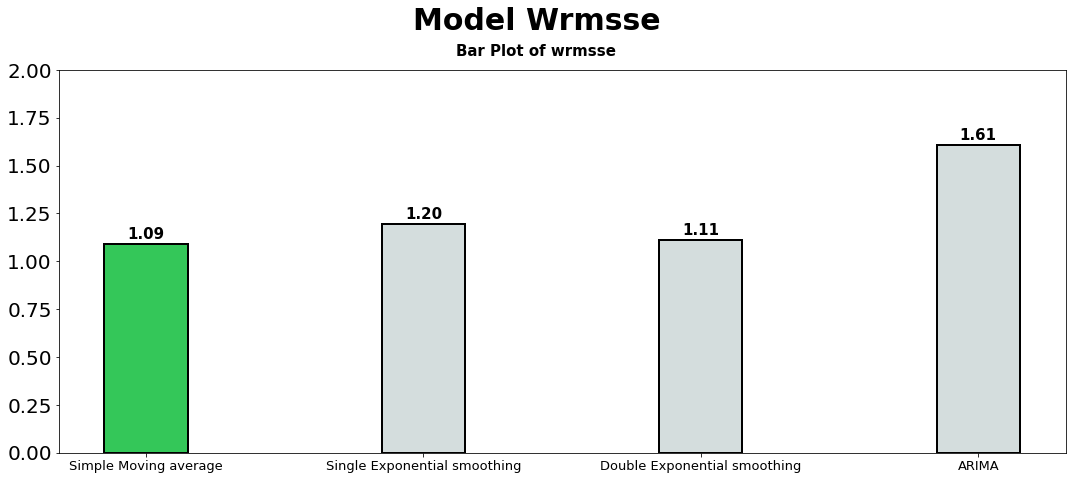

In [40]:
model = ["Simple Moving average",  "Single Exponential smoothing", 
         "Double Exponential smoothing", "ARIMA"]
error = [wrmsse_sma, wrmsse_ses, wrmsse_des, wrmsse_arima]
color_map = ['#d4dddd' for _ in range(len(model))]
color_map[np.argmin(error)] = light_palette[2]

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

bars = ax.bar(model, error, 
       color=color_map, width=0.3, 
       edgecolor='black', 
       linewidth=2)

for i in range(len(model)):
    ax.annotate(f"{error[i]:.02f}", xy=(i, error[i]+0.05), va = 'center', ha='center', fontsize=15, fontweight='bold') 
ax.set_ylim(0, 2)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=20)
fig.text(0.5, 1.05, 'Model Wrmsse', fontsize=30, fontweight='bold', ha='center')
fig.text(0.5, 0.99, 'Bar Plot of wrmsse', fontsize=15, fontweight='bold', ha='center')

fig.tight_layout()
plt.show()

# <a id=5-2></a>5.2 Tree Modeling

## <a id=5-2-1></a>(1) Setting

### Objective : Tweedie

<img src='https://raw.githubusercontent.com/AIdward/m5-forecasting/master/src/tweedie1.PNG' style='float:left; width:500px;'>

Tweedie loss to handle intermittent values : Setting the tweedie loss as an objective function will basically force the model to maximize the likelihood of that distribution and thus **predict the right amount of '0's**

<img src='https://raw.githubusercontent.com/AIdward/m5-forecasting/master/src/tweedie2.PNG' style='float:left; width:800px;'>

Based on our dataset distribution, we can expect the **optimal value** to be between **1 and 1.3**

## <a id=5-2-2></a>(2) LightGBM

### Split Data

- d_398 ~ d_1913 (4 years + 56 days) train set
- d_1914 ~ d_1941 (28 days) validation set
- d_1942 ~ d_1619 (28 days) test set

In [41]:
category_cols = ['item_id','store_id', 'cat_id', 'state_id', 'wday', 'month', 'snap']
useless_cols = ["id", "dept_id", "date","d", "sales", "wm_yr_wk", "weekday", "sell_price"]
train_cols = train.columns[~train.columns.isin(useless_cols)]

df = train.copy()
days_train = ['d_'+str(c) for c in range(1914-365*4-28*2-1, 1914)]
days_val = ['d_'+str(c) for c in range(1914, 1942)]
df = df.replace([np.inf, -np.inf], 0)
#df.iloc[:, -9:] = df.iloc[:, -9:].fillna(0.0)
X_train = df[df['d'].isin(days_train)==True][train_cols]
y_train = df[df['d'].isin(days_train)==True]["sales"]
X_val_df = df[df['d'].isin(days_val)==True]
X_val_df["date"] = pd.to_datetime(X_val_df["date"])
X_val_dff = pd.DataFrame()
for delta in range(0, 28):
    day = datetime(2016, 4, 25) + timedelta(days=delta)
    vl = X_val_df.loc[X_val_df.date == day]
    X_val_dff = pd.concat([X_val_dff, vl])

X_val = X_val_dff[train_cols]
y_val = X_val_dff["sales"]

### HP Tuning

In [45]:
def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        
        #"learning_rate": trial.suggest_uniform("learning_rate", 0.03, 0.05),
        #"lambda_l1": trial.suggest_uniform("lambda_l1", 0.0, 1),
        #"lambda_l2": trial.suggest_uniform("lambda_l2", 0.0, 1),
        
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        'metric': 'rmse',
        'verbose': -1,
        'boost_from_average': False,
        'n_estimators': 5000,
        "learning_rate": trial.suggest_uniform("learning_rate", 0.015, 0.03),
        "tweedie_variance_power": trial.suggest_uniform("tweedie_variance_power", 1.05, 1.3),
        "num_leaves": trial.suggest_int("num_leaves", 1500, 2500), 
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 3000, 5000),
        "max_bin": trial.suggest_int("max_bin", 200, 400),  
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.3, 0.5),
    }
    
    train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=category_cols)
    valid_data = lgb.Dataset(X_val, label = y_val, categorical_feature=category_cols)
                                                                                            # 진행상황 보고싶을때 None을 100으로
    lgbmodel = lgb.train(params_lgb, train_data, valid_sets=[valid_data], early_stopping_rounds=200,
                         feval=wrmsse_lgb, verbose_eval=None)
    wrmsse = evaluator.score(lgbmodel.predict(X_val).reshape(28, -1).T)
    
    return wrmsse

In [46]:
sampler = TPESampler(seed=42)
lgb_study = optuna.create_study(study_name="lgbm_parameter_opt", direction="minimize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=20)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'boosting_type': 'gbdt', 'objective': 'tweedie', 'metric': 'rmse', 'verbose': -1,
                        'boost_from_average': False, 'n_estimators': 5000}
lgb_best_hyperparams.update(lgb_base_hyperparams)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2021-05-31 16:18:08,076] A new study created in memory with name: lgbm_parameter_opt
[I 2021-05-31 17:04:12,425] Trial 0 finished with value: 0.5929399972739481 and parameters: {'learning_rate': 0.020618101782710438, 'tweedie_variance_power': 1.2876785766024792, 'num_leaves': 2232, 'min_data_in_leaf': 4197, 'max_bin': 231, 'feature_fraction': 0.4467983561008608}. Best is trial 0 with value: 0.5929399972739481.
[I 2021-05-31 17:54:02,437] Trial 1 finished with value: 0.6030496589065882 and parameters: {'learning_rate': 0.01587125418252299, 'tweedie_variance_power': 1.266544036443734, 'num_leaves': 2101, 'min_data_in_leaf': 4416, 'max_bin': 204, 'feature_fraction': 0.6909729556485982}. Best is trial 0 with value: 0.5929399972739481.
[I 2021-05-31 18:27:58,019] Trial 2 finished with value: 0.5876716259983509 and parameters: {'learning_rate': 0.027486639612006324, 'tweedie_variance_power': 1.1030847776695691, 'num_leaves': 1682, 'min_data_in_leaf': 3366, 'max_bin': 261, 'feature_fractio

The best hyperparameters are:
 {'learning_rate': 0.018770362054402065, 'tweedie_variance_power': 1.0527349836416215, 'num_leaves': 1899, 'min_data_in_leaf': 3718, 'max_bin': 337, 'feature_fraction': 0.4037791062361256, 'boosting_type': 'gbdt', 'objective': 'tweedie', 'metric': 'rmse', 'verbose': -1, 'boost_from_average': False, 'n_estimators': 5000}


In [232]:
fig = plot_slice(lgb_study)
fig.write_image("../img/lgb_plot_slice.png")

fig = plot_optimization_history(lgb_study)
fig.write_image("../img/lgb_plot_optimization_history.png")

fig = plot_param_importances(lgb_study)
fig.write_image("../img/lgb_plot_param_importances.png")

fig = plot_parallel_coordinate(lgb_study)
fig.write_image("../img/lgb_plot_parallel_coordinate.png")

### Train

In [47]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=category_cols)
valid_data = lgb.Dataset(X_val, label = y_val, categorical_feature=category_cols)

lgbmodel = lgb.train(lgb_best_hyperparams, train_data, valid_sets=[valid_data],
                     early_stopping_rounds=200, feval= wrmsse_lgb, verbose_eval=100)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.12437	valid_0's wrmsse: 0.918185
[200]	valid_0's rmse: 2.03291	valid_0's wrmsse: 0.652819
[300]	valid_0's rmse: 2.02241	valid_0's wrmsse: 0.599879
[400]	valid_0's rmse: 2.01915	valid_0's wrmsse: 0.585957
[500]	valid_0's rmse: 2.01796	valid_0's wrmsse: 0.578213
[600]	valid_0's rmse: 2.01811	valid_0's wrmsse: 0.576986
[700]	valid_0's rmse: 2.0184	valid_0's wrmsse: 0.576617
Early stopping, best iteration is:
[526]	valid_0's rmse: 2.01767	valid_0's wrmsse: 0.577628


In [48]:
evaluator.score(lgbmodel.predict(X_val).reshape(28, -1).T)

0.5776277196987923

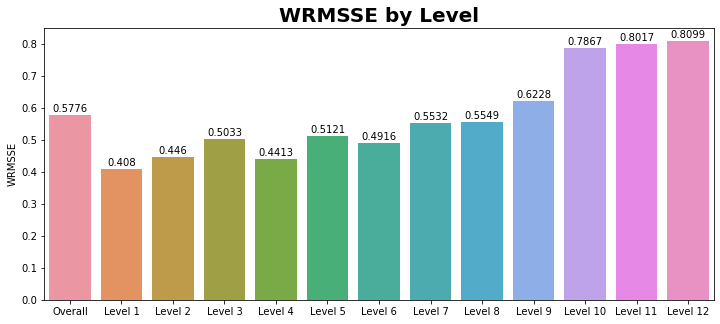

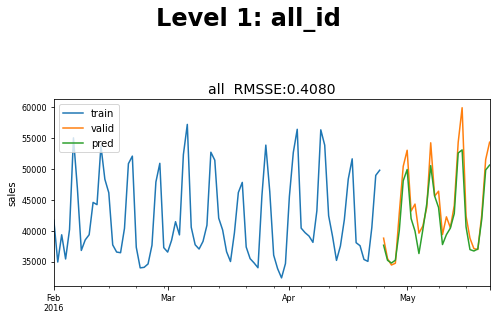

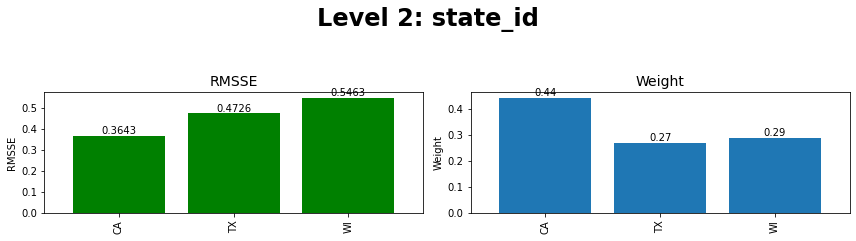

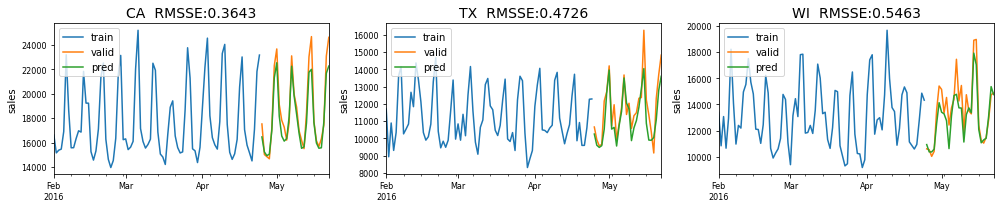

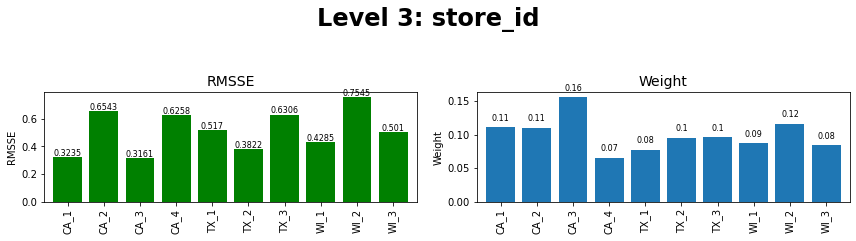

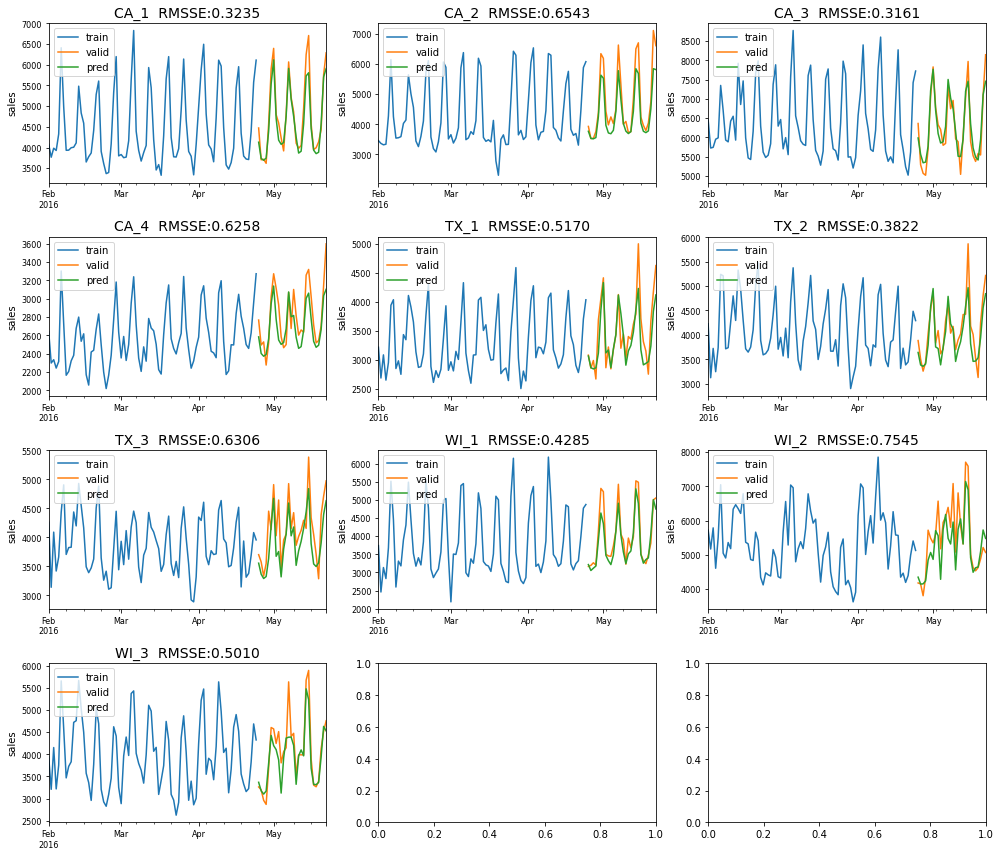

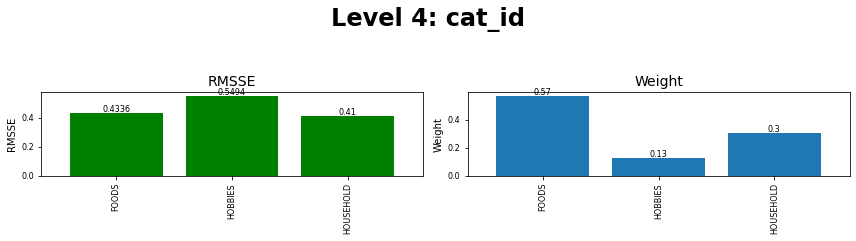

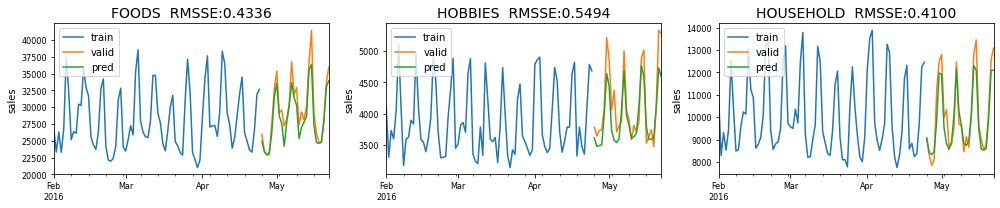

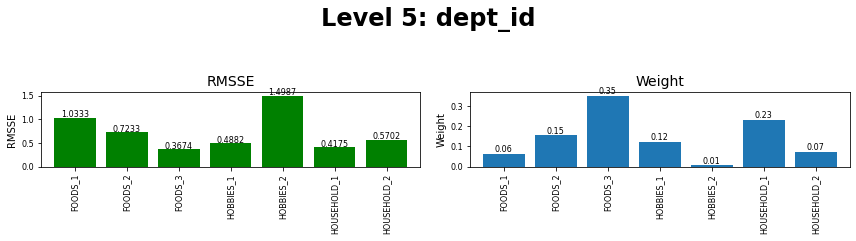

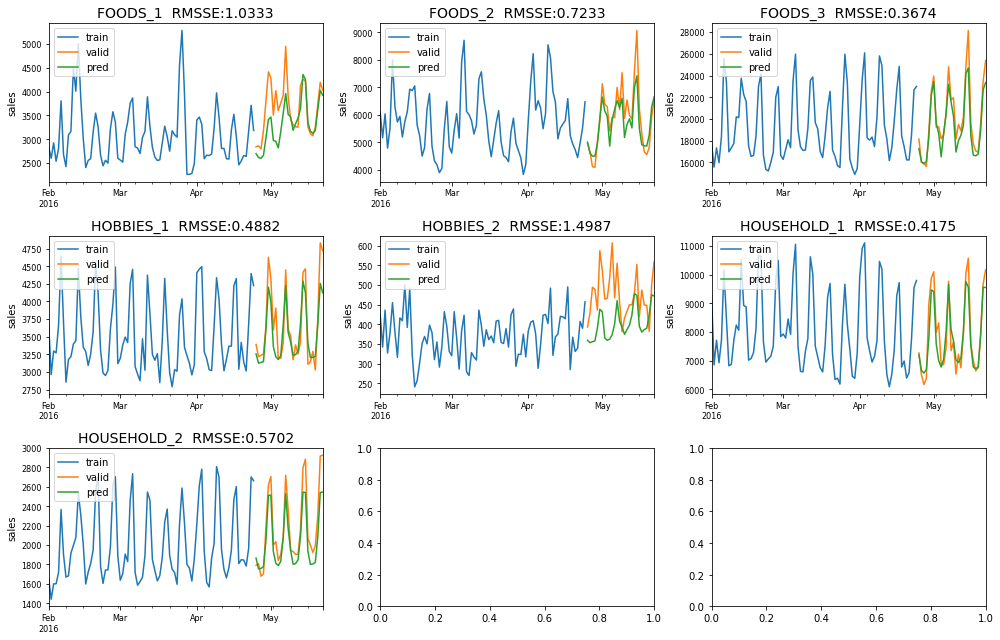

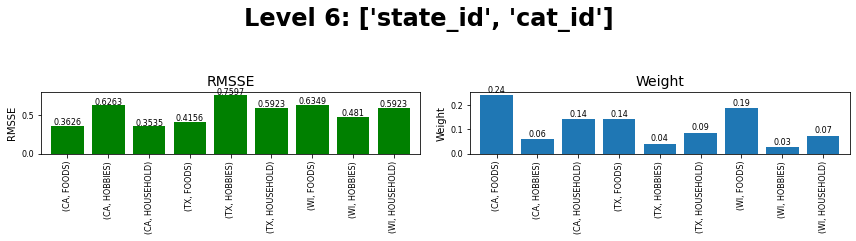

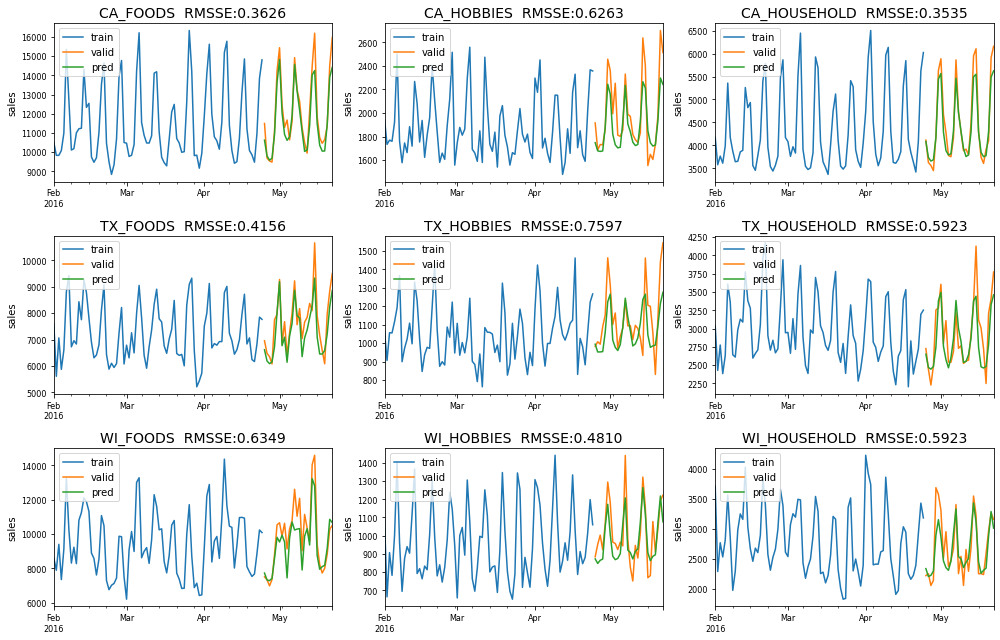

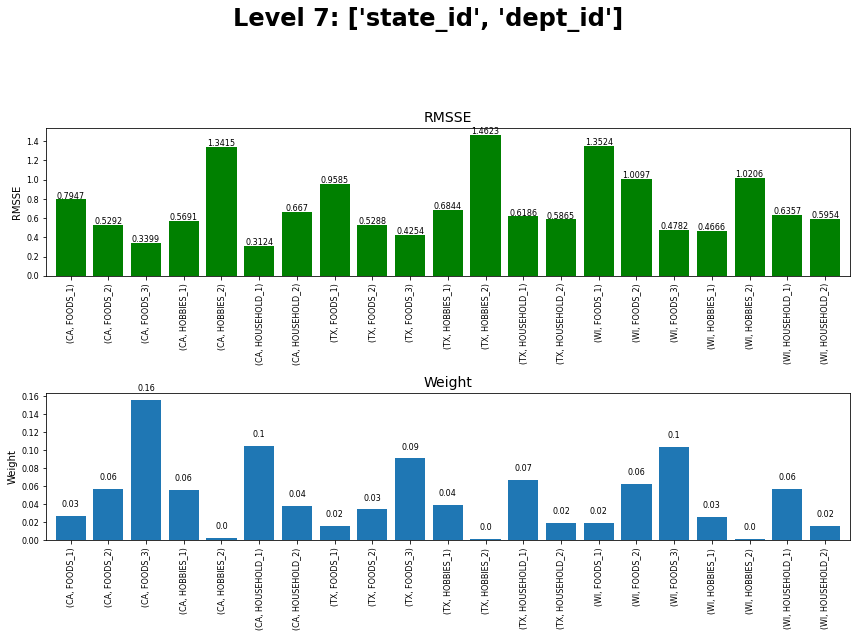

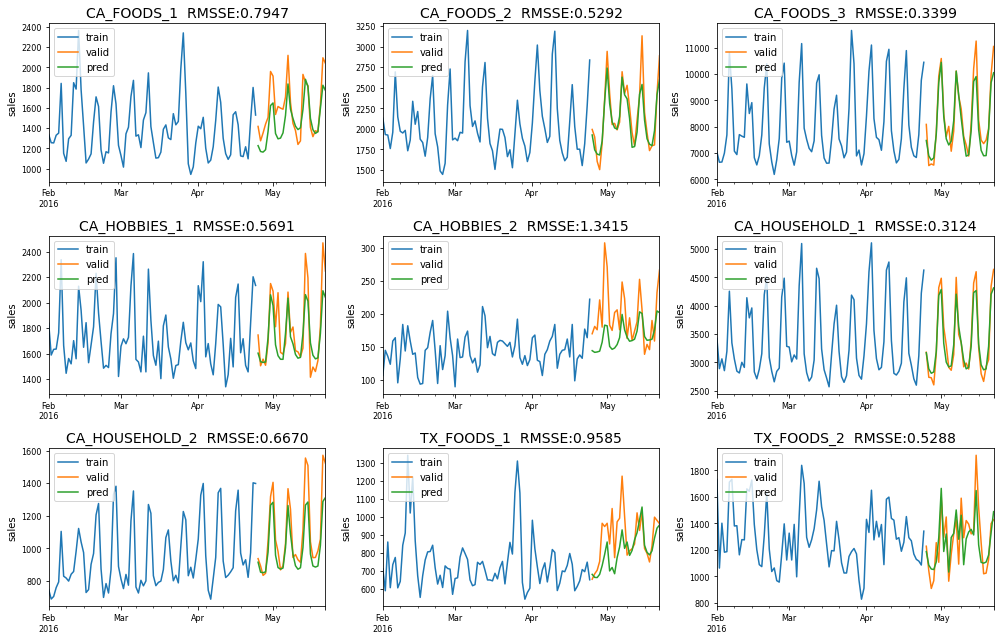

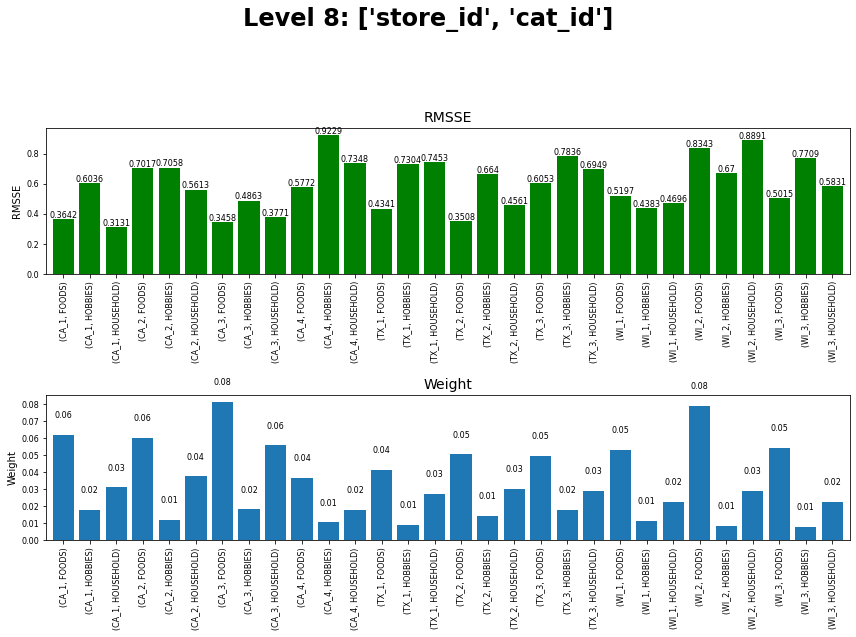

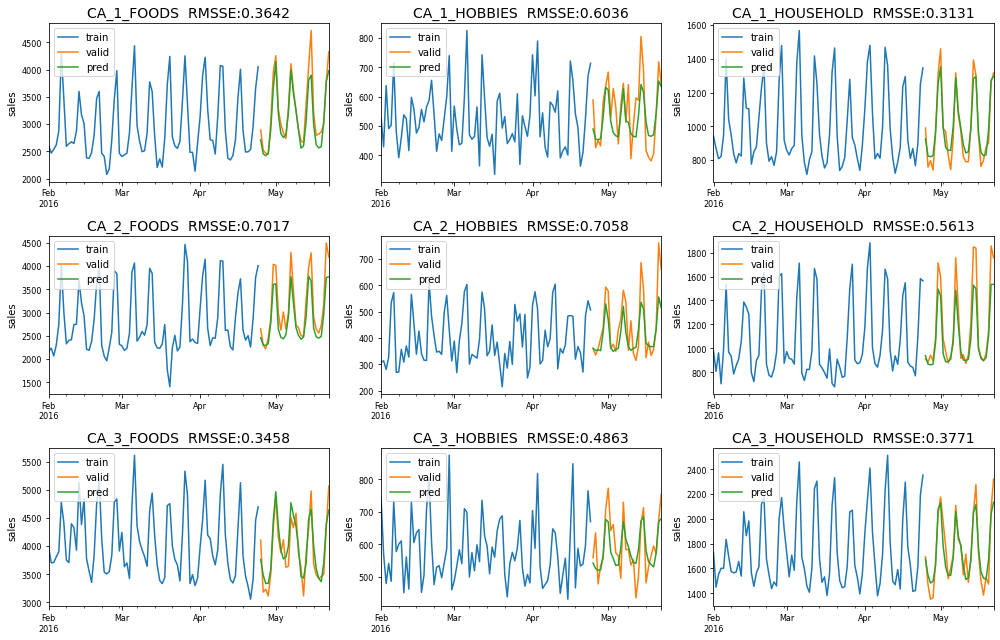

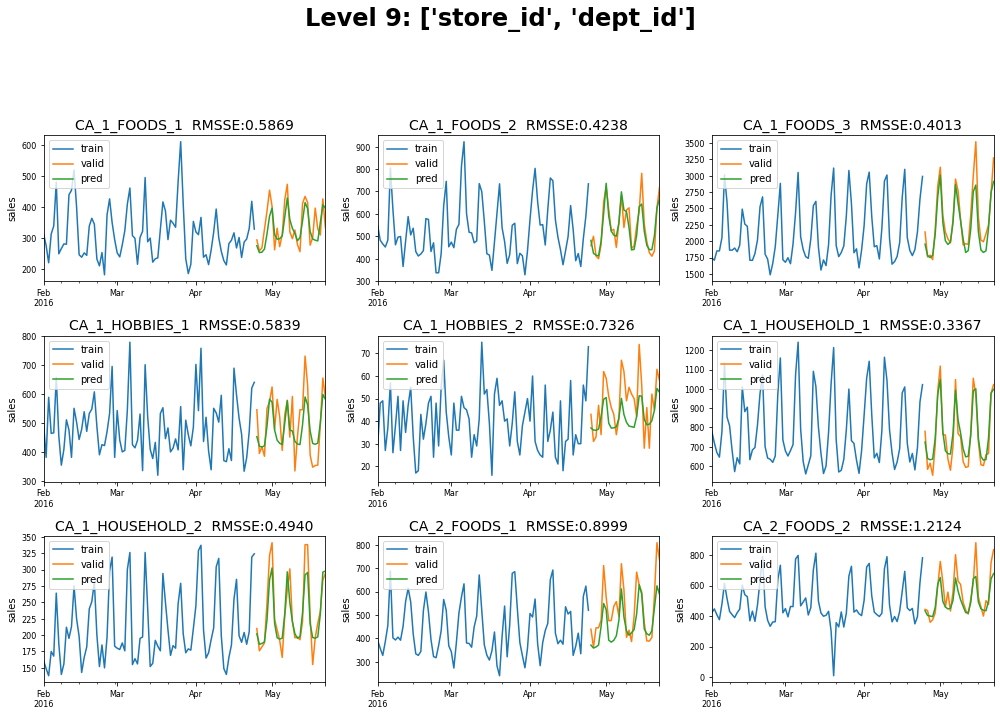

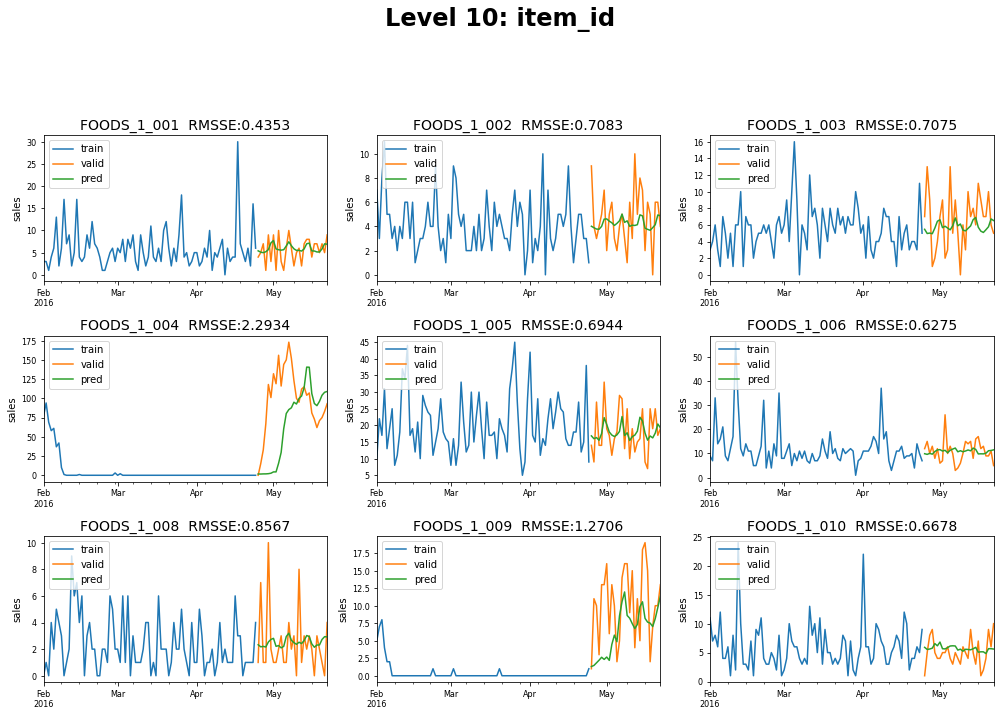

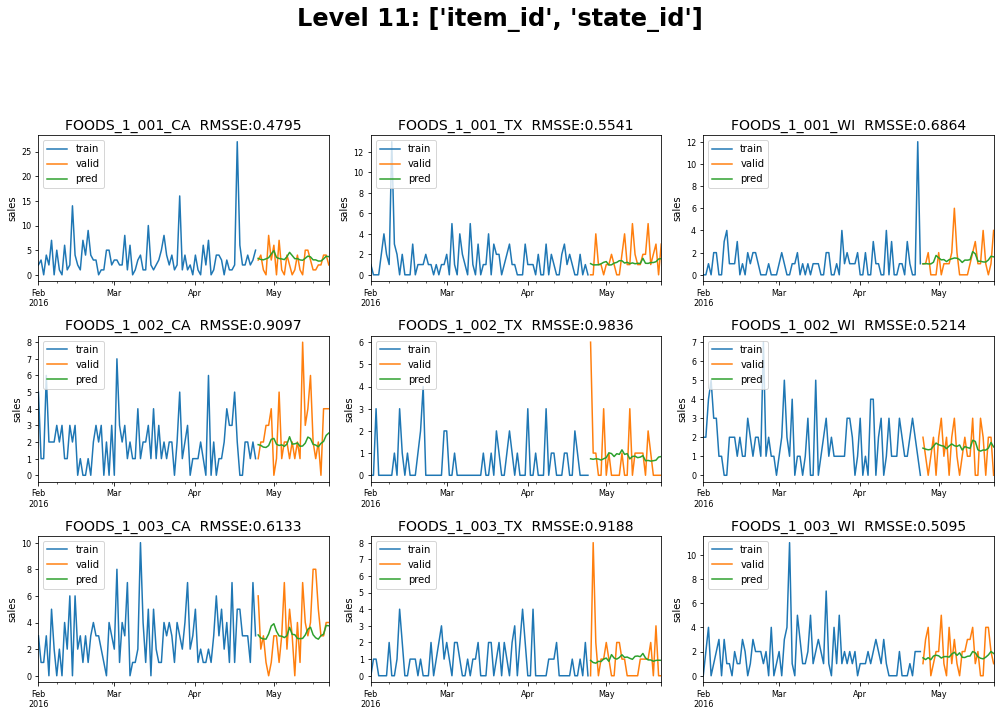

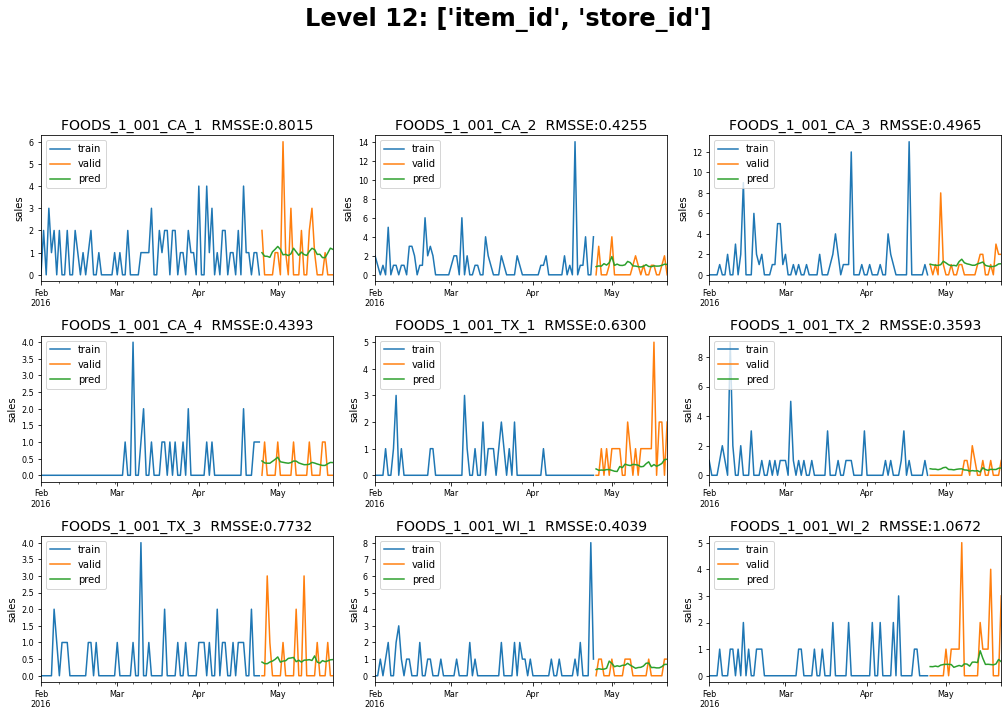

In [49]:
create_dashboard(evaluator)

### Predict

In [50]:
cols = [f"F{i}" for i in range(1,29)]
test["date"] = pd.to_datetime(test["date"])
for time_delta in range(0, 28):
    day = datetime(2016, 5, 23) + timedelta(days=time_delta)
    print("Predict", day.date())
    tst = test[(test.date >= day - timedelta(days=60)) & (test.date <= day)].copy()
    lags_wins(tst)
    tst = tst.loc[tst.date == day , train_cols]
    test.loc[test.date == day, "sales"] = lgbmodel.predict(tst)
    del(tst)

Predict 2016-05-23
Predict 2016-05-24
Predict 2016-05-25
Predict 2016-05-26
Predict 2016-05-27
Predict 2016-05-28
Predict 2016-05-29
Predict 2016-05-30
Predict 2016-05-31
Predict 2016-06-01
Predict 2016-06-02
Predict 2016-06-03
Predict 2016-06-04
Predict 2016-06-05
Predict 2016-06-06
Predict 2016-06-07
Predict 2016-06-08
Predict 2016-06-09
Predict 2016-06-10
Predict 2016-06-11
Predict 2016-06-12
Predict 2016-06-13
Predict 2016-06-14
Predict 2016-06-15
Predict 2016-06-16
Predict 2016-06-17
Predict 2016-06-18
Predict 2016-06-19


In [51]:
test_pred_y_lgb = np.zeros((30490, 1))
for i in range(0, 28):
    test_pred_y_lgb = np.hstack([
        test_pred_y_lgb, test.loc[test.date == (datetime(2016, 5, 23) + timedelta(days=i)), 'sales'].values.reshape(-1, 1)])
test_pred_y_lgb = np.delete(test_pred_y_lgb, 0, axis=1)

In [ ]:
with open('../pkl/test_pred_y_lgb.pickle', 'wb') as fw:
    pickle.dump(test_pred_y_lgb, fw)

## <a id=5-2-3></a>(3) XGBoost

### Split Data

- d_398 ~ d_1913 (4 years + 56 days) train set
- d_1914 ~ d_1941 (28 days) validation set
- d_1942 ~ d_1619 (28 days) test set

In [52]:
category_cols = ['item_id','store_id', 'cat_id', 'state_id', 'wday', 'month', 'snap']
useless_cols = ["id", "dept_id", "date","d", "sales", "wm_yr_wk", "weekday", "sell_price"]
train_cols = train.columns[~train.columns.isin(useless_cols)]

df = train.copy()
enc = LabelEncoder()
for col in df.columns:
    if df[col].dtype.name=='category':
        df[col] = enc.fit_transform(df[col])

df = df.replace([np.inf, -np.inf], 0)
days_train = ['d_'+str(c) for c in range(1914-365*4-28*2-1, 1914)]
days_val = ['d_'+str(c) for c in range(1914, 1942)]
#df.iloc[:, -9:] = df.iloc[:, -9:].fillna(0.0)
X_train = df[df['d'].isin(days_train)==True][train_cols]
y_train = df[df['d'].isin(days_train)==True]["sales"]
X_val_df = df[df['d'].isin(days_val)==True]
X_val_df["date"] = pd.to_datetime(X_val_df["date"])
X_val_dff = pd.DataFrame()
for delta in range(0, 28):
    day = datetime(2016, 4, 25) + timedelta(days=delta)
    vl = X_val_df.loc[X_val_df.date == day]
    X_val_dff = pd.concat([X_val_dff, vl])
X_val = X_val_dff[train_cols]
y_val = X_val_dff["sales"]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
watchlist = [(dvalid, 'valid')]

### HP Tuning

In [53]:
def xgb_objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": 91373,
        "verbose": None,
        "objective": "reg:tweedie",
        "max_bin": 16,
        #"max_depth": 12,
        "tree_method": 'gpu_hist', 
        "gpu_id": 0,
        #"learning_rate": 0.03,
        "tweedie_variance_power": trial.suggest_uniform("tweedie_variance_power", 1.05, 1.2),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.05, 0.2),
        #"reg_alpha": trial.suggest_uniform("reg_alpha", 0.5, 1.0), # default=0
        #"reg_lambda": trial.suggest_uniform("reg_lambda", 0.5, 1.0), # default=1
        "max_depth": trial.suggest_int("max_depth", 9, 13),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.4, 0.6), # default=0
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.1, 0.4),
        #"subsample": trial.suggest_uniform("subsample", 0.5, 0.8), # default=1
        "gamma": trial.suggest_uniform("gamma", 0.4, 0.7), # default=0
        #"min_child_weight": trial.suggest_uniform("min_child_weight", 5, 10), # default=1
    }
    
    
                                                                                            # 진행상황 보고싶을때 None을 100으로
    xgbmodel = xgb.train(params_xgb, dtrain, 8000, watchlist, early_stopping_rounds=200, feval=wrmsse_xgb, verbose_eval=None)
    
    wrmsse = evaluator.score(xgbmodel.predict(dvalid).reshape(28, -1).T)

    return wrmsse

In [54]:
sampler = TPESampler(seed=42)
xgb_study = optuna.create_study(study_name="xgbm_parameter_opt", direction="minimize", sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=30)

xgb_best_hyperparams = xgb_study.best_trial.params
xgb_base_hyperparams = {"random_state": 91373, "verbose": None, "objective": "reg:tweedie", "max_bin": 16, 
                        "tree_method": 'gpu_hist', "gpu_id": 0}
xgb_best_hyperparams.update(xgb_base_hyperparams)
print("The best hyperparameters are:\n", xgb_best_hyperparams)

[I 2021-06-01 10:29:12,340] A new study created in memory with name: xgbm_parameter_opt
[I 2021-06-01 10:36:02,249] Trial 0 finished with value: 0.6316582183181042 and parameters: {'tweedie_variance_power': 1.1061810178271043, 'learning_rate': 0.19260714596148742, 'max_depth': 12, 'colsample_bytree': 0.5197316968394073, 'colsample_bylevel': 0.14680559213273098, 'gamma': 0.4467983561008608}. Best is trial 0 with value: 0.6316582183181042.
[I 2021-06-01 10:42:49,046] Trial 1 finished with value: 0.6220321532926668 and parameters: {'tweedie_variance_power': 1.05871254182523, 'learning_rate': 0.1799264218662403, 'max_depth': 12, 'colsample_bytree': 0.5416145155592091, 'colsample_bylevel': 0.10617534828874074, 'gamma': 0.6909729556485982}. Best is trial 1 with value: 0.6220321532926668.
[I 2021-06-01 10:49:21,443] Trial 2 finished with value: 0.6402012952578148 and parameters: {'tweedie_variance_power': 1.1748663961200632, 'learning_rate': 0.08185086660174143, 'max_depth': 9, 'colsample_byt

[I 2021-06-01 13:53:09,056] Trial 23 finished with value: 0.6161825074509008 and parameters: {'tweedie_variance_power': 1.1411240350762106, 'learning_rate': 0.05225931580965123, 'max_depth': 9, 'colsample_bytree': 0.5427740798951194, 'colsample_bylevel': 0.3572564604981243, 'gamma': 0.6061469517914544}. Best is trial 4 with value: 0.6119793337891344.
[I 2021-06-01 14:03:04,951] Trial 24 finished with value: 0.6152230120396854 and parameters: {'tweedie_variance_power': 1.127233068786346, 'learning_rate': 0.10026443656636096, 'max_depth': 13, 'colsample_bytree': 0.44686901286190944, 'colsample_bylevel': 0.25376030398100546, 'gamma': 0.6931690459321072}. Best is trial 4 with value: 0.6119793337891344.
[I 2021-06-01 14:11:41,495] Trial 25 finished with value: 0.6119977274399814 and parameters: {'tweedie_variance_power': 1.0994133370484147, 'learning_rate': 0.08850131933243788, 'max_depth': 11, 'colsample_bytree': 0.4127820023001909, 'colsample_bylevel': 0.29963753348130107, 'gamma': 0.6302

The best hyperparameters are:
 {'tweedie_variance_power': 1.1009005809523253, 'learning_rate': 0.1124357654715222, 'max_depth': 11, 'colsample_bytree': 0.41174157144768747, 'colsample_bylevel': 0.2903984415974088, 'gamma': 0.6202372226587107, 'random_state': 91373, 'verbose': None, 'objective': 'reg:tweedie', 'max_bin': 16, 'tree_method': 'gpu_hist', 'gpu_id': 0}


In [233]:
fig = plot_slice(xgb_study)
fig.write_image("../img/xgb_plot_slice.png")

fig = plot_optimization_history(xgb_study)
fig.write_image("../img/xgb_plot_optimization_history.png")

fig = plot_param_importances(xgb_study)
fig.write_image("../img/xgb_plot_param_importances.png")

fig = plot_parallel_coordinate(xgb_study)
fig.write_image("../img/xgb_plot_parallel_coordinate.png")

### Train

In [55]:
xgbmodel = xgb.train(xgb_best_hyperparams, dtrain, 8000, watchlist, 
                     early_stopping_rounds=200, feval=wrmsse_xgb, verbose_eval=100)

[0]	valid-tweedie-nloglik@1.1009:15.38529	valid-wrmsse:7.71275
[100]	valid-tweedie-nloglik@1.1009:14.30073	valid-wrmsse:7.15402
[200]	valid-tweedie-nloglik@1.1009:14.29831	valid-wrmsse:7.16355
[211]	valid-tweedie-nloglik@1.1009:14.29814	valid-wrmsse:7.16379


In [56]:
evaluator.score(xgbmodel.predict(dvalid).reshape(28, -1).T)

0.6082970576678911

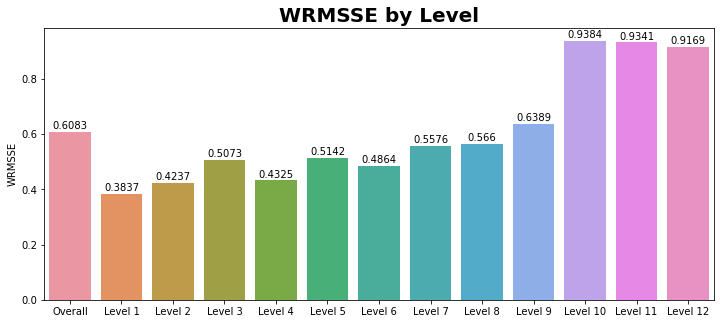

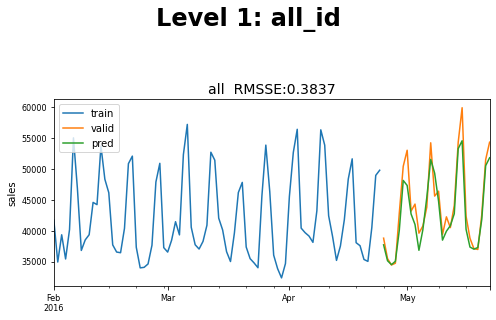

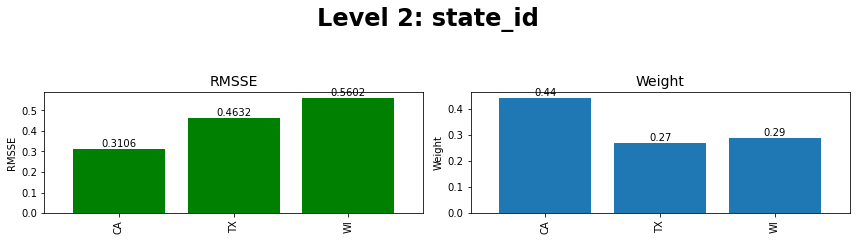

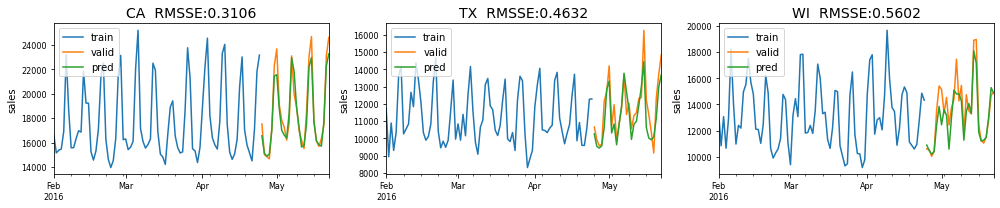

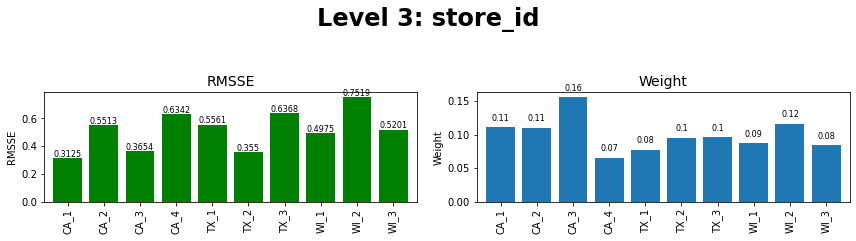

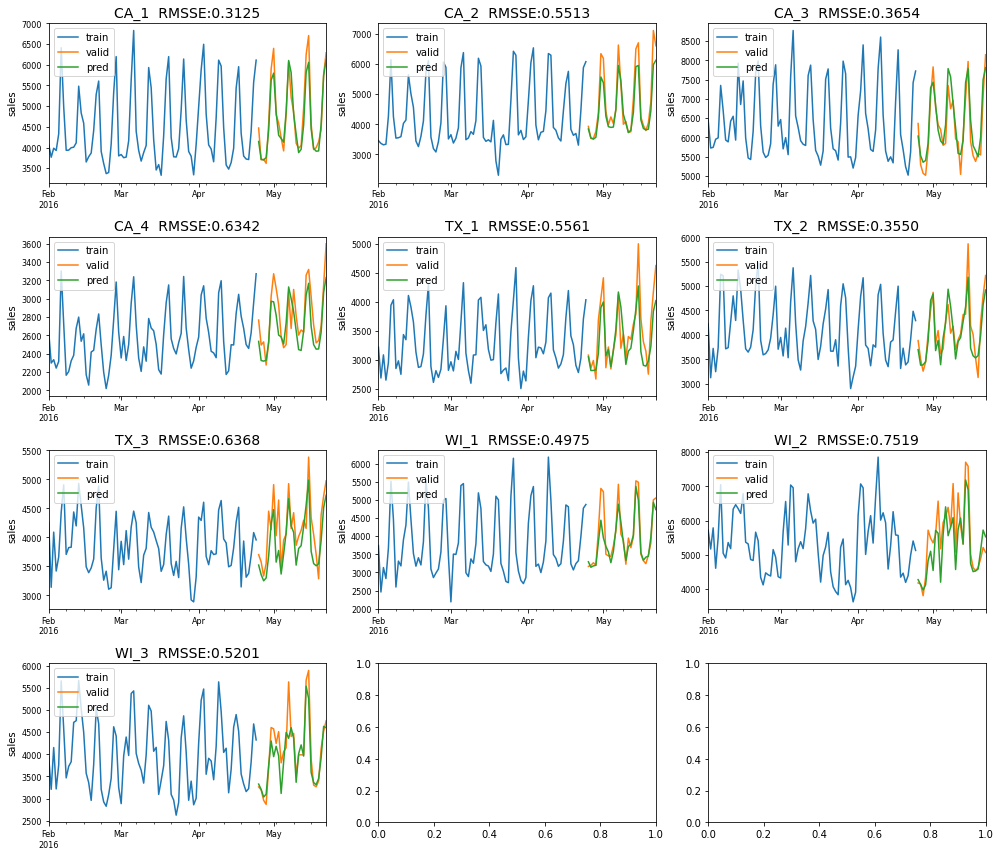

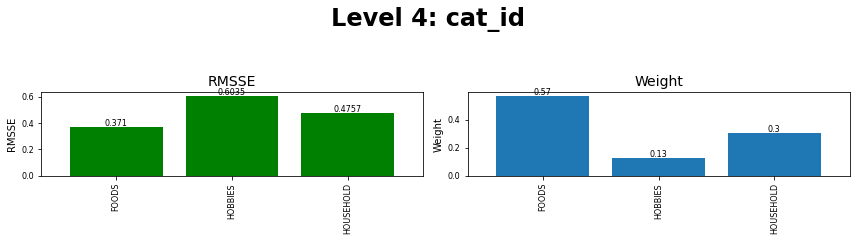

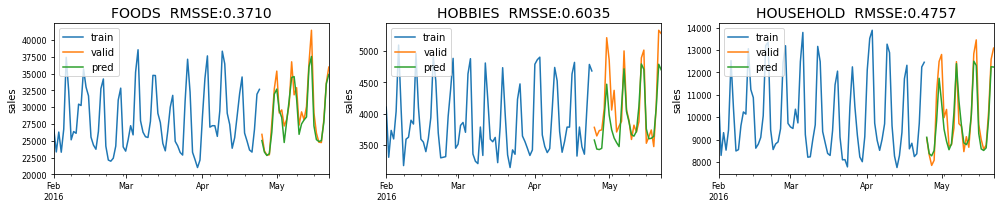

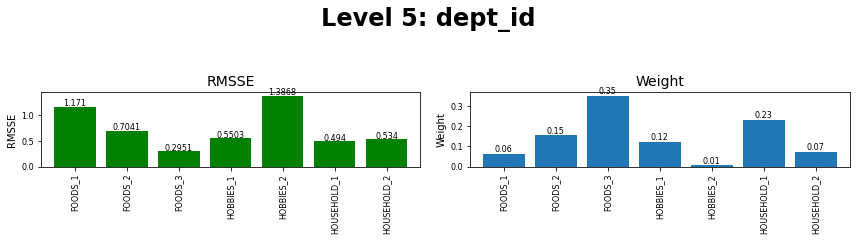

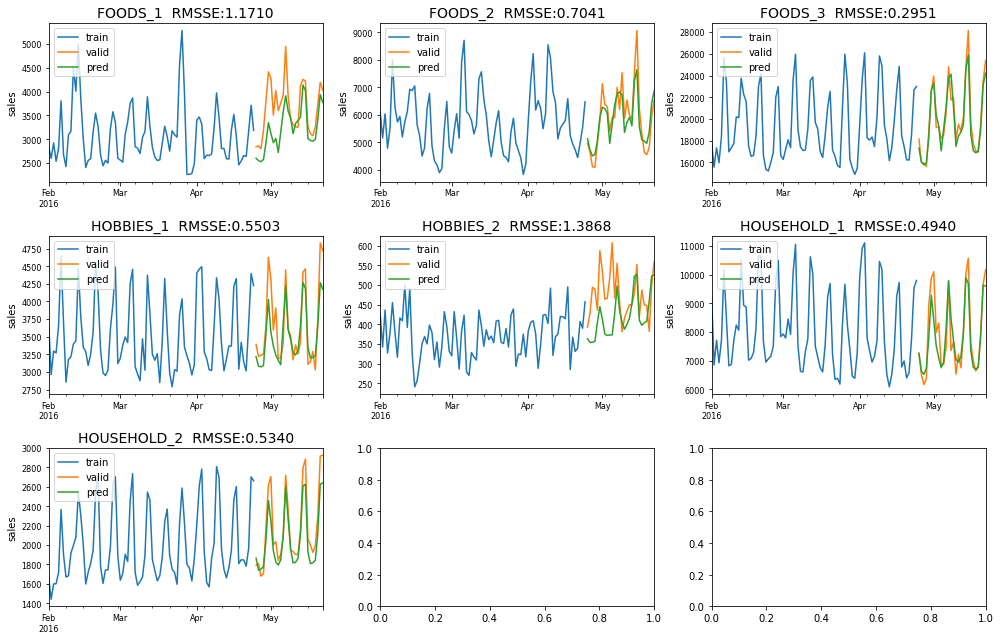

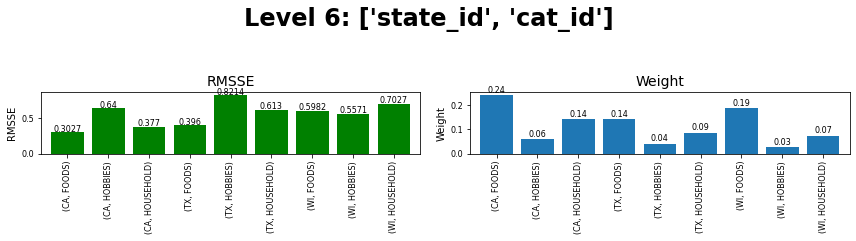

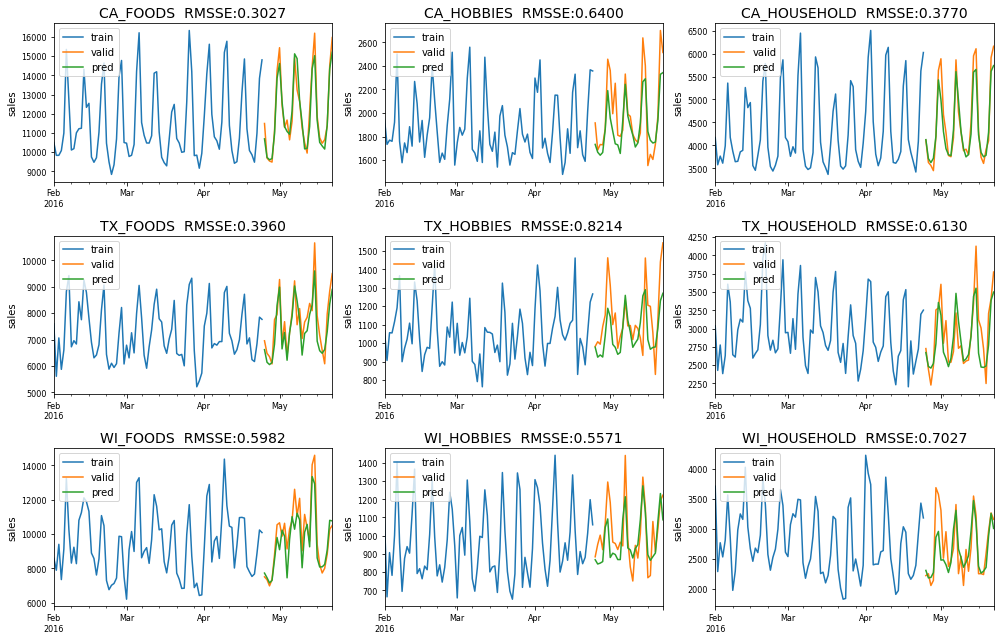

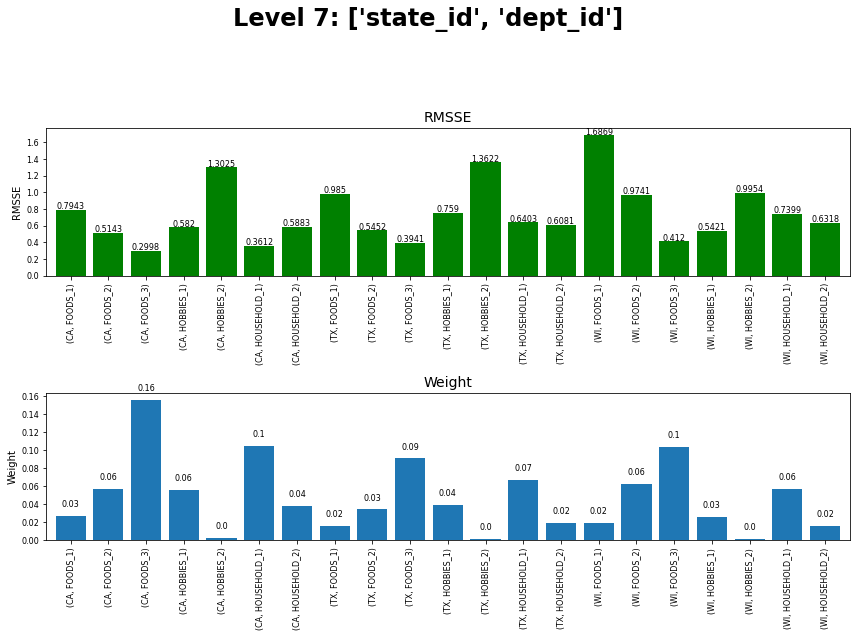

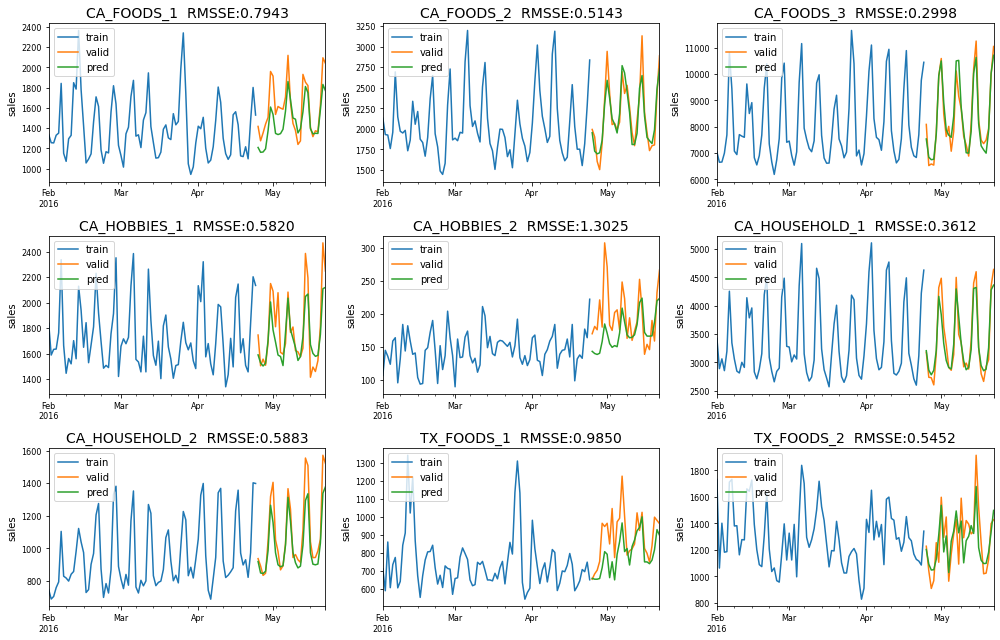

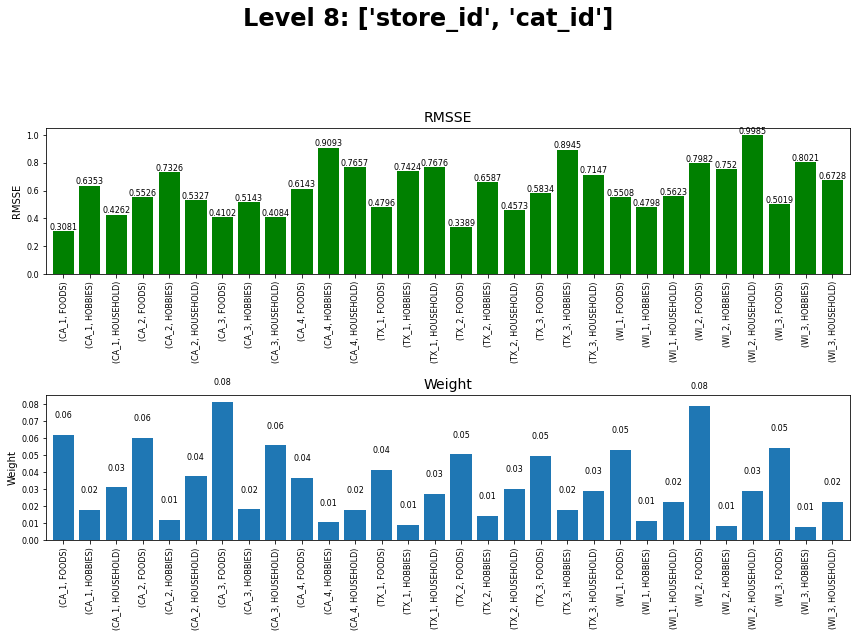

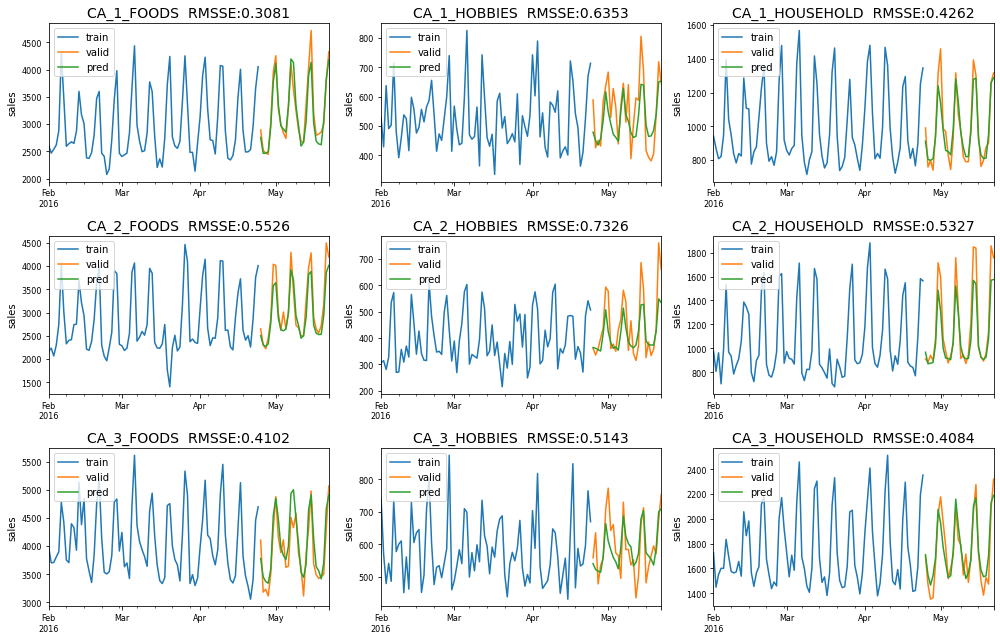

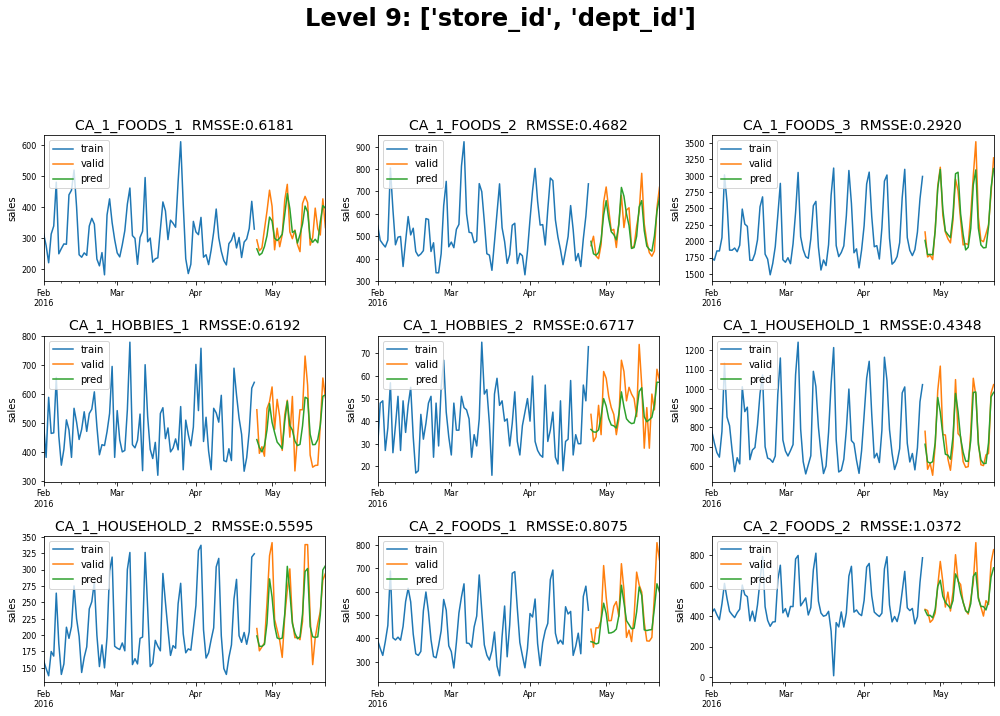

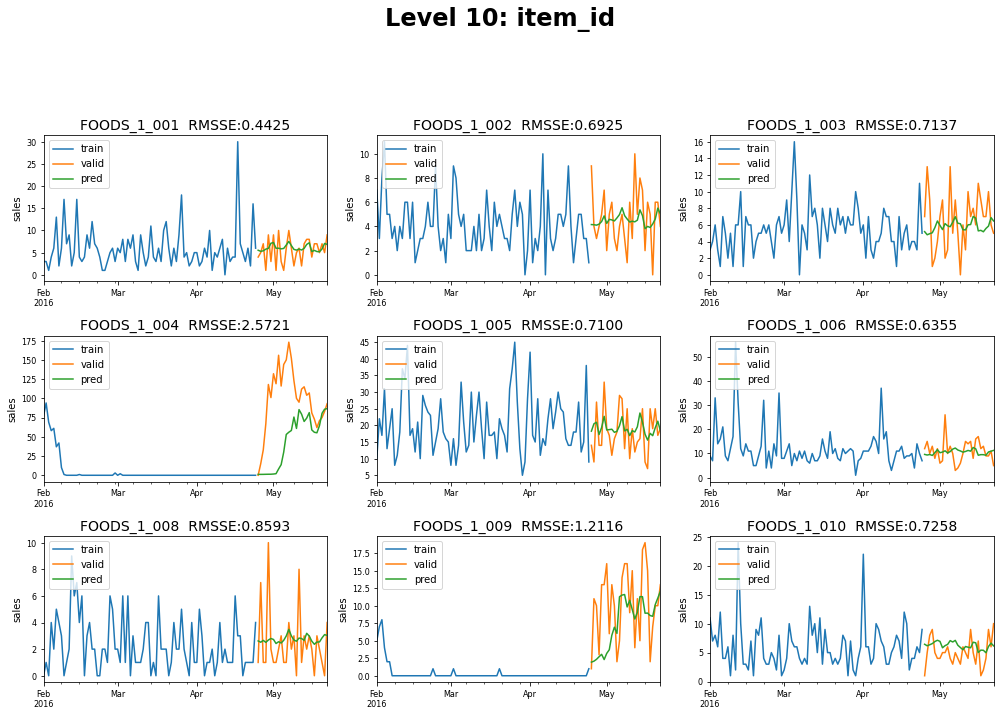

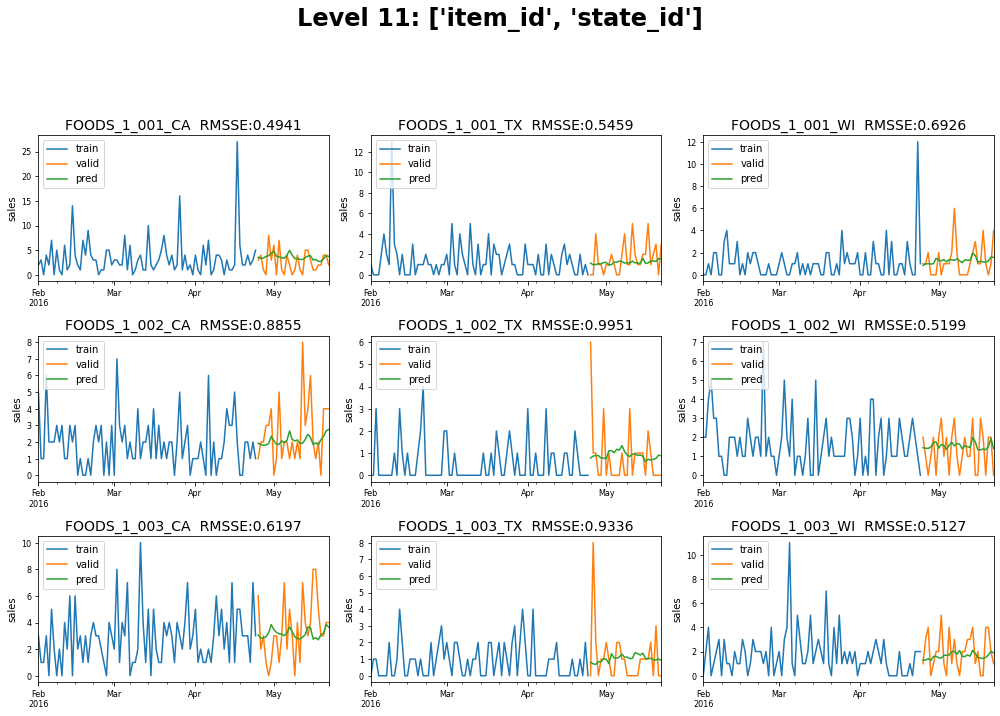

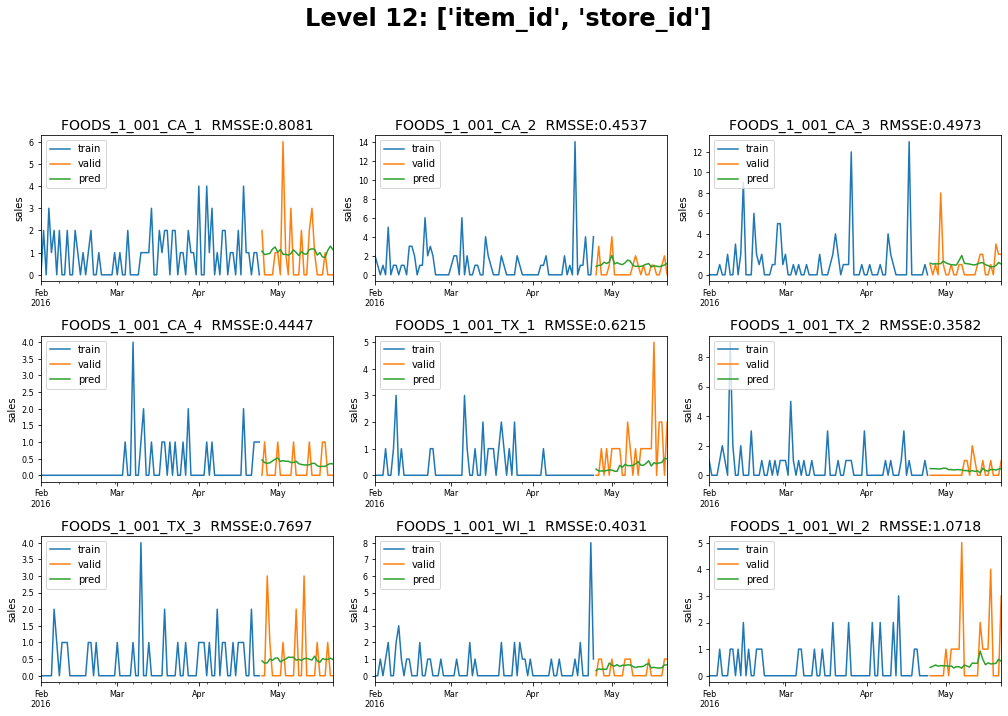

In [57]:
create_dashboard(evaluator)

### Predict

In [58]:
cols = [f"F{i}" for i in range(1,29)]
test["date"] = pd.to_datetime(test["date"])
df = train.copy()
df_enc = df[['item_id', 'store_id', 'cat_id', 'state_id']]
for col in df_enc.columns:
    df_enc[col] = enc.fit(df_enc[col])
    test[col] = enc.transform(test[col])

In [59]:
for time_delta in range(0, 28):
    day = datetime(2016, 5, 23) + timedelta(days=time_delta)
    print("Predict", day.date())
    tst = test[(test.date >= day - timedelta(days=60)) & (test.date <= day)].copy()
    lags_wins(tst)
    tst = tst.loc[tst.date == day , train_cols]
    test.loc[test.date == day, "sales"] = xgbmodel.predict(xgb.DMatrix(tst))
    del(tst)

Predict 2016-05-23
Predict 2016-05-24
Predict 2016-05-25
Predict 2016-05-26
Predict 2016-05-27
Predict 2016-05-28
Predict 2016-05-29
Predict 2016-05-30
Predict 2016-05-31
Predict 2016-06-01
Predict 2016-06-02
Predict 2016-06-03
Predict 2016-06-04
Predict 2016-06-05
Predict 2016-06-06
Predict 2016-06-07
Predict 2016-06-08
Predict 2016-06-09
Predict 2016-06-10
Predict 2016-06-11
Predict 2016-06-12
Predict 2016-06-13
Predict 2016-06-14
Predict 2016-06-15
Predict 2016-06-16
Predict 2016-06-17
Predict 2016-06-18
Predict 2016-06-19


In [60]:
test_pred_y_xgb = np.zeros((30490, 1))
for i in range(0, 28):
    test_pred_y_xgb = np.hstack([
        test_pred_y_xgb, test.loc[test.date == (datetime(2016, 5, 23) + timedelta(days=i)), 'sales'].values.reshape(-1, 1)])
test_pred_y_xgb = np.delete(test_pred_y_xgb, 0, axis=1)
val_true_y = pd.read_csv('../../m5-data/sales_train_evaluation.csv', dtype=SALES_DTYPES).iloc[:, -28:].values

In [61]:
with open('../pkl/test_pred_y_xgb.pickle', 'wb') as fw:
    pickle.dump(test_pred_y_xgb, fw)

# <a id='6'><font size=6>6. Ensemble</font></a>

## <a id=6-1></a>(1) Blending

In [229]:
test_pred_y_final = (
    test_pred_y_sma * 0.12 +
    #test_pred_y_ses * 0.1 +
    test_pred_y_des * 0.08 +
    test_pred_y_lgb * 0.7 +
    test_pred_y_xgb * 0.1
                    )

In [230]:
submission = pd.read_csv('../../m5-data/sample_submission.csv')
submission.iloc[:30490, 1:] = val_true_y
submission.iloc[30490:, 1:] = test_pred_y_final

In [231]:
submission.to_csv("../submission/40.csv",index=False)

# <a id='7'><font size=6>7. Other Trials</font></a>

다양한 시도를 하였으나 Private Score에 긍정적인 영향을 주지 못한 것들을 정리

## <a id=7-1></a>(1) Calendar Features

- Event day와 Snap day를 원 핫 인코딩, 레이블 인코딩하여 학습 시도
- 4주를 한 주 씩 나누어 새로운 feature 생성하여 학습 시도

## <a id=7-2></a>(2) Lag Features

- Lag를 (7, 14, 28)이 아닌 (1, 7, 14, 28)로 놓고 학습 -> no recursive에는 성능이 좋으나 recursive 예측에는 성능 저하
- window size (7, 14, 28)에 60을 추가하여 학습

## <a id=7-3></a>(3) Tree Modeling

- objective를 tweedie가 아닌 rmse와 poisson으로 학습
- wrmsse custom metric 없이 early stopping 시도하거나 early stopping 없이 학습
- Train set을 4년+58일치 데이터가 아닌 단순 4년치 데이터, 5년치 데이터로 설정
- Optuna로 HP튜닝을 할 때 early stopping metric을 wrmsse가 아닌 rmse로 두고 튜닝

## <a id=7-4></a>(4) Neural Network Modeling

- RNN, LSTM을 시도하였으나 학습시간 대비 성능이 좋지 않으므로 제거 (blending을 하여도 성능 저하)

## <a id=7-5></a>(5) Blending

- 시계열 모델 가중치는 0.2일 때, 트리 모델 가중치는 0.8일 때만 예측 정확도 상승

<center><a href="#top" class="btn btn-success btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Move to TOP</a><center>